# Nitrocefin biochemistry - Michaelis–Menten kinetics

Absorbance data were generated experimentally as described. For each plate, the buffer-only well absorbance was subtracted from each datapoint (done outside this script). A standard curve of absorbance versus hydrolyzed nitrocefin concentration was generated, and a linear fit of these data was used to calculate an absolute concentration of hydrolyzed nitrocefin for each sample. For each  sequence-ampicillin concentration, a linear regression was calculated for all possible sliding windows of 4 timepoints (approximately 1.15 minutes) for each for replicates. The maximum slope was selected and the quality of fit was verified by normalized rmsd as well as by eye. Samples S70A, consensus, and 70.b had no detectable hydrolosis (N/H) and samples 50.a and 50.b were unable to be purified (N/A). 

The michaelis menten equation was fit once for each variant using the $lmfit$ python library, and the stderr (plotted as error bars) was used directly from $lmfit$. For the kcat/Km error bars, we applied error propagation (https://en.wikipedia.org/wiki/Propagation_of_uncertainty):

$\sigma_{kcat/kM} = |kcat/kM| \sqrt( (\sigma_{kcat}/kcat)^2 + (\sigma_{Km}/Km)^2)$

Note: data were fit to a maximum substrate concentration of 400 $\mu$M as we observed inhibition at 800 $\mu$M nitrocefin for some designs, but if the resulting Km was less than $1/3$ of the the maximum substrate concentration ($1/3$ of $400 \mu$M $~= 133.3 \mu$M) and there was no clear substrate inhibition at 800 $\mu$M, then data were then re-fit to the maximum measured substrate concentration 800 $\mu$M. Designs fit to the 800 $\mu$M maximum were WT TEM-1, 98.b, 90.b, opt.b. All other designs were fit to a maximum of 400 $\mu$M nitrocefin

## Imports and Constants

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt 
from scipy.stats import linregress
import seaborn as sns
import matplotlib as mpl
from lmfit import Model,Parameters

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/nitrocefin_biochemistry'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

RAW_DATA_SHEETNAME = 'biochem_nitrocefin_raw'

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
# Read in the raw data
wide_df = pd.read_excel(
    FHS.get_data_filename(), 
    sheet_name=RAW_DATA_SHEETNAME
).iloc[0:315,].rename(
    columns={'uM': 'uM_substrate'}
)

wide_df = FHS.add_manuscript_name_to_df(
    wide_df, 
    synonym_column='Design',
    new_column='manuscript_name'
).drop('Design', axis='columns')

#read in standard curve
std_curve_df = pd.read_excel(
    FHS.get_data_filename(), 
    sheet_name=RAW_DATA_SHEETNAME,
    header=319
).iloc[0:6,0:3].rename(columns={1.0: 'rep1_absorbance', 2.0: 'rep2_absorbance'})

In [5]:
#perform a linear regression on the standard curve
std_curve_regression = linregress(
    list(std_curve_df.uM) + list(std_curve_df.uM), 
    list(std_curve_df.rep1_absorbance) + list(std_curve_df.rep2_absorbance)
)

In [6]:
# Melt the dataframe to put the time variable in a column
narrow_df = wide_df.melt(
    id_vars=['manuscript_name','Rep', 'uM_substrate'],
    var_name="time_secs",
    value_name="absorbance"
)

narrow_df['time_min'] = narrow_df['time_secs'] / 60

#convert absorbance to uM using standard curve
narrow_df['uM_product'] = narrow_df.absorbance.apply(
    lambda absorbance: (
        absorbance-std_curve_regression.intercept
    )/std_curve_regression.slope
)
narrow_df = narrow_df.dropna()

## Analysis Functions

In [7]:
##############################################################
### Sliding window linear regression and rmsd calculation ####
##############################################################

#
# calculate the rmsd
#
def calculate_rmsd(slope, intersect, actual_x_values, actual_y_values):
    predicted_values = []
    for actual_x in actual_x_values:
        predicted_values.append(
            slope * actual_x + intersect
        )
    return np.sqrt(
        np.sum(
            (np.array(predicted_values) - np.array(actual_y_values)) ** 2
        ) / len(predicted_values)
    )

#
# repeately perform a linear regression on each variant over the number
# of timepoints specified by 'window_size'.
#
def window_linear_regression(narrow_df, window_size=5):
    lin_reg_data = []

    for manuscript_name in np.unique(narrow_df.manuscript_name):
        for rep_num in np.unique(narrow_df.Rep):
            sample_rep_df = narrow_df[
                (narrow_df.manuscript_name == manuscript_name) & 
                (narrow_df.Rep == rep_num)
            ]
            
            for substrate_conc in np.unique(sample_rep_df.uM_substrate):
                conditions = sample_rep_df[
                    (sample_rep_df.uM_substrate == substrate_conc)
                ].sort_values(by='time_min', ascending=True)
                
                for i in range(0, len(conditions)-window_size):
                    window_times = conditions[i:i+window_size].time_min.tolist()
                    window_conc_product = conditions[i:i+window_size].uM_product.tolist()
                    res = linregress(window_times, window_conc_product)
                    rmsd = calculate_rmsd(
                        res.slope, res.intercept, 
                        pd.array(window_times), 
                        pd.array(window_conc_product)
                    )
                    value = {
                        'manuscript_name': manuscript_name,
                        'rep_num': rep_num,
                        'uM_substrate': substrate_conc,
                        'start_time_index': i,
                        'start_time_min': window_times[0],
                        'end_time_min': window_times[len(window_times)-1],
                        'slope': res.slope,
                        'intercept': res.intercept,
                        'window_time_mins': pd.array(window_times),
                        'window_uM_products': pd.array(window_conc_product),
                        'rmsd': rmsd,
                        'nrmsd': rmsd / (np.max(window_conc_product) - np.min(window_conc_product))#normalized rmsd
                    }
                    lin_reg_data.append(value)
    toreturn = pd.DataFrame.from_dict(lin_reg_data)
    return toreturn

In [8]:
linregress_df = window_linear_regression(narrow_df, window_size=4)

/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_17073/4077248332.py:60: RuntimeWarning: invalid value encountered in double_scalars
  'nrmsd': rmsd / (np.max(window_conc_product) - np.min(window_conc_product))#normalized rmsd
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_17073/4077248332.py:60: RuntimeWarning: invalid value encountered in double_scalars
  'nrmsd': rmsd / (np.max(window_conc_product) - np.min(window_conc_product))#normalized rmsd
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_17073/4077248332.py:60: RuntimeWarning: invalid value encountered in double_scalars
  'nrmsd': rmsd / (np.max(window_conc_product) - np.min(window_conc_product))#normalized rmsd
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_17073/4077248332.py:60: RuntimeWarning: invalid value encountered in double_scalars
  'nrmsd': rmsd / (np.max(window_conc_product) - np.min(window_conc_product))#normalized rmsd
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipy

In [9]:
#check what values were throwing the division by zero error
linregress_df[pd.isna(linregress_df.nrmsd)].manuscript_name.unique()

array(['neg. ctrl', 'rw-consensus'], dtype=object)

In [10]:
def determine_max_slopes(manuscript_name):
    toreturn = {
        'manuscript_name': [],
        'uM_substrate': [],
        'rep_num': [],
        'total_time': [],
        'slope': [],
        'intercept': [],
        'window_time_mins': [],
        'rmsd': [],
        'nrmsd': [],
    }
    var_df = linregress_df[
        linregress_df.manuscript_name==manuscript_name
    ]

    for idx, uM_substrate in enumerate(np.sort(var_df.uM_substrate.unique())):
        
        raw_df = narrow_df[(
            (narrow_df.manuscript_name==manuscript_name) &
            (narrow_df.uM_substrate==uM_substrate)
        )]
        
        var_sub_df = var_df[var_df.uM_substrate==uM_substrate]
        for rep_num in var_sub_df.rep_num.unique():
            #raw_values = raw_df[raw_df.Rep == rep_num].uM_product
            #spread_raw = np.max(raw_values) - np.min(raw_values)
            #rmsd_cutoff = spread_raw / 50
            #var_sub_df = var_sub_df[var_sub_df.rmsd <= rmsd_cutoff]

            line = var_sub_df[var_sub_df.rep_num==rep_num].sort_values(
                by=['slope'], ascending=False
            ).iloc[0:1,]

            if len(line) > 0:
                toreturn['manuscript_name'].append(manuscript_name)
                toreturn['uM_substrate'].append(uM_substrate)
                toreturn['rep_num'].append(rep_num)
                toreturn['total_time'].append(
                    list(line.end_time_min)[0] - list(line.start_time_min)[0]
                )
                toreturn['slope'].append(list(line.slope)[0])
                toreturn['intercept'].append(list(line.intercept)[0])
                toreturn['window_time_mins'].append(list(line.window_time_mins))
                toreturn['rmsd'].append(list(line.rmsd)[0])
                toreturn['nrmsd'].append(list(line.nrmsd)[0])
    return pd.DataFrame(toreturn)

In [11]:
def get_max_slopes_df():
    '''
    for all sequences, determinet the maximum slope for each replicate/substrate 
    concentration as a single dataframe. 
    '''
    toreturn = None
    for manuscript_name in linregress_df.manuscript_name.unique():
        tmp_slopes_df = determine_max_slopes(manuscript_name)
        if toreturn is None: toreturn = tmp_slopes_df
        else:
            toreturn = pd.concat([toreturn, tmp_slopes_df])
    return toreturn

final_slopes_df = get_max_slopes_df()

In [12]:
##see https://www.anotherscienceblog.com/post/the-michaelis-menten-enzyme-kinetics-model
def michaelis_menten_equation(S,E,Km,kcat):
    return kcat*E*S/(Km+S)

def get_kcat_over_Km_stderr(
    kcat, kcat_stderr, Km, Km_stderr
):
    return math.sqrt(
        ( kcat_stderr / kcat )**2 + ( Km_stderr / Km )**2
    ) * (
        kcat / Km
    )

def get_michaelis_menten_parameters():
    toreturn = {
        'manuscript_name': [],
        'max_substrate_conc': [],
        'Km': [],
        'Km_stderr': [],
        'kcat': [],
        'kcat_stderr': [],
        'kcat_over_Km': [],
        'kcat_over_Km_stderr': []
    }
    enzyme_conc=.001 #Enzyme conc = 1nM = .001uM
    for name in final_slopes_df.manuscript_name.unique():
        def fit(include_800 = False):
            
            data = final_slopes_df[(
                (final_slopes_df.manuscript_name == name)
            )]
            if not include_800:
                data = data[data.uM_substrate != 800]
            
            substrate_conc=data.uM_substrate #substrate conc in uM
            slopes=data.slope 

            # Create and fit model
            mdl = Model(michaelis_menten_equation)
            params = Parameters()
            params.add("E", value=enzyme_conc, vary=False)
            params.add("Km", value=1e-3,min=0, max=1e9, vary=True)
            params.add("kcat", value=1e5, min=0, max=1e9, vary=True)
            result = mdl.fit(
                slopes,
                params=params,
                S=substrate_conc
            )
            return result
        result = fit(include_800 = False)
        max_substrate_conc = 400
        
        if result.params['Km'].value * 3 > 400 and name not in ["opt.a", "70.a"]: 
            #add 800uM substrate and reanalyze if Km*3 < max substrate (400 uM).
            #do not do for opt.a as it is clearly inhibiting at 800 uM
            print("{0} - including 800uM substrate".format(name))
            result = fit(include_800 = True)
            max_substrate_conc = 800
        
        toreturn['manuscript_name'].append(name)
        toreturn['max_substrate_conc'].append(max_substrate_conc)
        toreturn['Km'].append(result.params['Km'].value)
        toreturn['Km_stderr'].append(result.params['Km'].stderr)
        toreturn['kcat'].append(result.params['kcat'].value)
        toreturn['kcat_stderr'].append(result.params['kcat'].stderr)
        toreturn['kcat_over_Km'].append(
            result.params['kcat'].value / result.params['Km'].value
        )
        #error propagation for the kcat/km:
        #https://en.wikipedia.org/wiki/Propagation_of_uncertainty
        if name in ['50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus']:
            toreturn['kcat_over_Km_stderr'].append(0)
        else: 
            toreturn['kcat_over_Km_stderr'].append(
                get_kcat_over_Km_stderr(
                    result.params['kcat'].value,
                    result.params['kcat'].stderr,
                    result.params['Km'].value,
                    result.params['Km'].stderr,
                )
            )
    return pd.DataFrame(toreturn)

In [13]:
# output errors as percent of actual data
def get_errors_as_percentage(df):
    toreturn = {
        'manuscript_name': [],
        'Km_stderr_percent': [],
        'kcat_stderr_percent': [],
        'kcat_over_Km_stderr_percent': [],
    }
    params = ['Km', 'kcat', 'kcat_over_Km']
    if 'Ki' in df.columns: 
        params.append('Ki')
        toreturn['Ki_stderr_percent'] = []

    for idx, row in df.iterrows():
        toreturn['manuscript_name'].append(row.manuscript_name)
        for param in params:
            val = row[param]
            stderr = row['{0}_stderr'.format(param)]
            toreturn[
                '{0}_stderr_percent'.format(param)
            ].append(
                stderr / val * 100
            )
    return pd.DataFrame(toreturn)

In [14]:
# 
# output values for supplement table 
# - format for LaTeX if latex==True
#
def output_table(df, latex=True):
    table_df = pd.concat([ #add 50's so they appear in the table
        df,
        pd.DataFrame({
            'manuscript_name': ['50.a', '50.b']
        })
    ])
    table_df = table_df.assign(
        order = lambda df: table_df.manuscript_name.apply(
            lambda n: FHS.get_sample_order(table_df.manuscript_name).index(n)
        )
    ).sort_values( by="order" ).reset_index(drop=True)
    if latex:
        no_hydrolysis_samples = ['neg. ctrl', 'rw-consensus', '70.b']
        unpurifiable_samples = ['50.a', '50.b']
        for idx, row in table_df.iterrows():
            gap_and_color = '\\rule[-2ex]{0pt}{0pt}' + ('' if idx % 2 == 0 else '\\rowcolor{lightlightgray} ')
            if row.manuscript_name in no_hydrolysis_samples or row.manuscript_name in unpurifiable_samples:
                text = 'no hydrolysis' if row.manuscript_name in no_hydrolysis_samples else 'unable to purify'
                print(
                    row.manuscript_name + ' & \multicolumn{3}{c}{'+text+'} \\tabularnewline \\hline'#\n\midrule[.5pt]'
                )
            else:
                print(
                    '{0} & {1} & {2} & {3} \\tabularnewline{4}'.format(
                        row.manuscript_name,
                        '${0:.0f} \\pm {1:.0f}$'.format(round(row.Km), round(row.Km_stderr)),
                        '${0:.0f} \\pm {1:.0f}$'.format(round(row.kcat), round(row.kcat_stderr)),
                        '${0:.0f} \\pm {1:.0f}$'.format(round(row.kcat_over_Km), round(row.kcat_over_Km_stderr)),
                        ' \\hline'#'\n\midrule[.5pt]' if idx != len(table_df)-1 else ''
                    )
                )
    return table_df

## Visualization Functions

In [15]:
#
# plot how well the parameter fit agrees with data.
#
def plot_parameter_fit(params_df, equation, filename_to_save=None):
    num_cols = 4
    fig, axes = plt.subplots(nrows=4, ncols=num_cols, sharex=True)
    fig.suptitle('slope vs substrate concentration', fontsize=16)

    fig.set_size_inches(9, 9)
    axes = axes.flatten()
    colors = { 1: 'red', 2: 'green', 3: 'blue' }

    samples_with_no_mm_kinetics = [
        "neg. ctrl", "rw-consensus", "70.b", "50.a", "50.b"
    ]
    
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    for idx, samplename in enumerate(sample_order):
        ax = axes[idx]
        if idx > 2: ax = axes[idx+1]
        sns.scatterplot(
            data=final_slopes_df[final_slopes_df.manuscript_name==samplename], 
            x='uM_substrate', y='slope', 
            hue='rep_num', s=10, palette=colors,
            ax=ax,
        )

        #overlay mm fit
        if samplename not in samples_with_no_mm_kinetics:
            enzyme_conc=.001 #Enzyme conc = 1nM = .001uM
            plotting_df = params_df[
                params_df.manuscript_name==samplename
            ]
            sample_rep_row = plotting_df.iloc[0]
            data = {'x': [], 'y': []}
            xrange = sample_rep_row.max_substrate_conc
                
            for x in range(0, xrange):
                
                if 'Ki' in params_df.columns:
                    y = equation(
                        x,
                        enzyme_conc,
                        sample_rep_row.Km,
                        sample_rep_row.kcat,
                        sample_rep_row.Ki
                    )
                else: 
                    y = equation(
                        x,
                        enzyme_conc,
                        sample_rep_row.Km,
                        sample_rep_row.kcat,
                    )
                
                data['x'].append(x)
                data['y'].append(y)
            data = pd.DataFrame(data)
            sns.lineplot(
                data, x='x', y='y', 
                size=0.5,
                ax=ax,
            )
        
        ax.set_title(samplename, fontsize=13)
        ax.get_xaxis().set_ticks([0, 200, 400, 600, 800])
        ax.xaxis.set_tick_params(labelsize=9)
        ax.yaxis.set_tick_params(labelsize=9)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.get_legend().remove()
        for ax in axes:
            for spine in ax.spines.values():
                spine.set_edgecolor('#a9a9a9')
        
        if idx % num_cols == 0: 
            ax.set_ylabel('slope', fontsize=10)
        
    fig.tight_layout(rect=[0, 0.01, 1, 0.99])
    if filename_to_save: fig.savefig(filename_to_save)

In [16]:
#
# barplot of km, kcat and kcat/km, output in the expected sample order.
# ignored_samples: these samples will be set to zero - useful for the
#                  michaelis menten with inhibition
# 
#
def plot_kinetics(df, ignored_samples=[], filename_to_save=None):
    fig, axes = plt.subplots(nrows=1, ncols=3)#, sharex=True)
    fig.set_size_inches(9.75, 2.75)
    axes = axes.flatten()

    #add 50.a and 50.b so they appear, and remove data for that had 
    #no hydrolosis (otherwise outliers ruin the plot)
    no_data_samples = ['50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus'] + ignored_samples
    zeros = [0 for name in no_data_samples]
    plotting_df = pd.concat([
        df[~df.manuscript_name.isin(no_data_samples)].copy(),
        pd.DataFrame({
            'manuscript_name': no_data_samples,
            'Km': zeros,
            'Km_stderr': zeros,
            'kcat': zeros,
            'kcat_stderr': zeros,
            'kcat_over_Km': zeros,
            'kcat_over_Km_stderr': zeros
        })
    ]).reset_index(drop=True)
    
    #reorder to standard order
    sample_order = FHS.get_sample_order(plotting_df.manuscript_name)
    plotting_df = plotting_df.assign(
        order = lambda df: df.manuscript_name.apply(
            lambda n: sample_order.index(n)
        )
    ).sort_values( by="order" ).reset_index(drop=True)
    
    for idx, variable in enumerate(['Km', 'kcat', 'kcat_over_Km']):
        #barplot of average with errobar
        ax = axes[idx]
        bp = sns.barplot(
            data=plotting_df,
            x='manuscript_name', 
            y=variable, 
            color='lightgray',
            errorbar='sd',
            ax=ax
        )
        ax.errorbar(
            x = [idx for idx in range(0, len(plotting_df))], 
            y = plotting_df[variable],
            yerr=plotting_df['{0}_stderr'.format(variable)], 
            fmt='none', c= 'black', capsize = 2
        )
        ax.set_title('{0} (nitrocefin)'.format(variable), fontsize=10)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        if variable=='kcat':
            ax.set_ylim(0, 44000)
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 4), useOffset=False)

        ax.set_xlim(-.55, 16.55)

        for idx2, samplename in enumerate(sample_order):
            #print('{0} : {1} : {2}'.format(samplename, idx2, bp.patches[idx2]))
            bar_details = bp.patches[idx2]
            x=bar_details.xy[0] + (bar_details.get_width() / 2)

            if samplename in ['neg. ctrl', 'rw-consensus', '70.b', '50.a', '50.b']:
                val='N/H'
                if samplename in ['50.a', '50.b']: val='N/A'
                ax.text(
                    x=x, y=0,
                    horizontalalignment='center', verticalalignment='bottom',
                    s=val, fontsize=6
                )
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
            label.set_fontsize(7)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    if filename_to_save:
        fig.savefig(filename_to_save)

In [17]:
def plot_best_slopes(filename_to_save = None):
    '''
    plot the raw data, and draw the top selected slope for each individual
    replicate
    '''
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    ordered_substrates = np.sort(narrow_df.uM_substrate.unique())
    nrows = len(sample_order)
    ncols = len(ordered_substrates)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
    #fig.suptitle('product vs time for each substrate concentration', fontsize=16)
    fig.set_size_inches(nrows*2, ncols*5)
    axes = axes.flatten()
    
    colors = { 1: 'red', 2: 'green', 3: 'blue' }
    for idx1, manuscript_name in enumerate(sample_order):
        for idx2, sub_conc in enumerate(ordered_substrates):
            idx = ncols*idx1 + idx2
            ax = axes[idx]
            
            #plot data
            sns.scatterplot( 
                data=narrow_df[(
                    (narrow_df['manuscript_name'] == manuscript_name) &
                    (narrow_df['uM_substrate'] == sub_conc)
                )],
                x='time_min', 
                y='uM_product', 
                hue='Rep',#data['uM_product'],
                palette=colors,
                size=10,
                ax = ax,
            )

            #remove the legend from individual plots - only have one above
            ax.get_legend().remove()

            #plot fit
            for rep_num in [1,2,3]:
                line = final_slopes_df[(
                    (final_slopes_df.manuscript_name==manuscript_name) &
                    (final_slopes_df.uM_substrate==sub_conc) &
                    (final_slopes_df.rep_num==rep_num)
                )]
                x = np.array(list(line.window_time_mins)).flatten()
                y = list(line.slope)[0] * x + list(line.intercept)
                ax.plot(
                    x, y, linewidth=0.5, color=colors[rep_num], 
                    label='linear regression with max slope (replicate {0})'.format(rep_num)
                )
            
            ax.set_ylabel(None)
            if idx1 == 0: ax.set_title('{0} μM substrate'.format(sub_conc), fontsize=16)
            if idx2 == 0: ax.set_ylabel('{0}\nμM product'.format(manuscript_name), fontsize=15)
            ax.set_xlabel('time (minutes)', fontsize=15)
    
    handles, labels = axes[0].get_legend_handles_labels()
    #for handle in handles: 
    #    handle.set_markersize(10)
    #    handle.set_markeredgewidth(4)
    fig.legend(
        handles[0:3] + handles[4:7], ['Replicate 1', 'Replicate 2', 'Replicate 3'] + labels[4:7], 
        bbox_to_anchor=(0.5, 1.0),
        loc='lower center',
        ncols=3,
        fontsize=18
    )
    fig.tight_layout(rect=[0, 0.01, 1, 1])
    if filename_to_save: fig.savefig(filename_to_save)

## Analysis - standard Michaelis-Menten equation

In [18]:
final_mm_parameters_df = get_michaelis_menten_parameters()
final_mm_parameters_df.to_csv(OUTPUT_DIR+'/final_nitrocefin_parameters.tab', sep='\t')

90.b - including 800uM substrate
98.b - including 800uM substrate
WT TEM-1 - including 800uM substrate
opt.b - including 800uM substrate


**Output standard errors (inferred fit vs raw data). Other than the samples that had no hydrolosis (i.e., not 70.b, neg. ctrl, rw-consensus), errors are quite reasonable.**

In [19]:
get_errors_as_percentage(final_mm_parameters_df)

,manuscript_name,Km_stderr_percent,kcat_stderr_percent,kcat_over_Km_stderr_percent
0,70.a,9.502653,4.221962,10.398335
1,70.b,12253.856602,17.659040,0.000000
2,80.a,12.132200,3.862527,12.732218
3,80.b,8.121456,2.930483,8.633990
4,90.a,9.712347,2.979662,10.159137
5,90.b,12.240409,4.742800,13.127138
6,95.a,16.219019,4.724092,16.893005
7,95.b,8.451803,2.532888,8.823180
8,98.a,8.601095,3.020031,9.115889
9,98.b,12.309064,4.102853,12.974839


**Output michaelis menten fit to raw data (supplementary figure)**

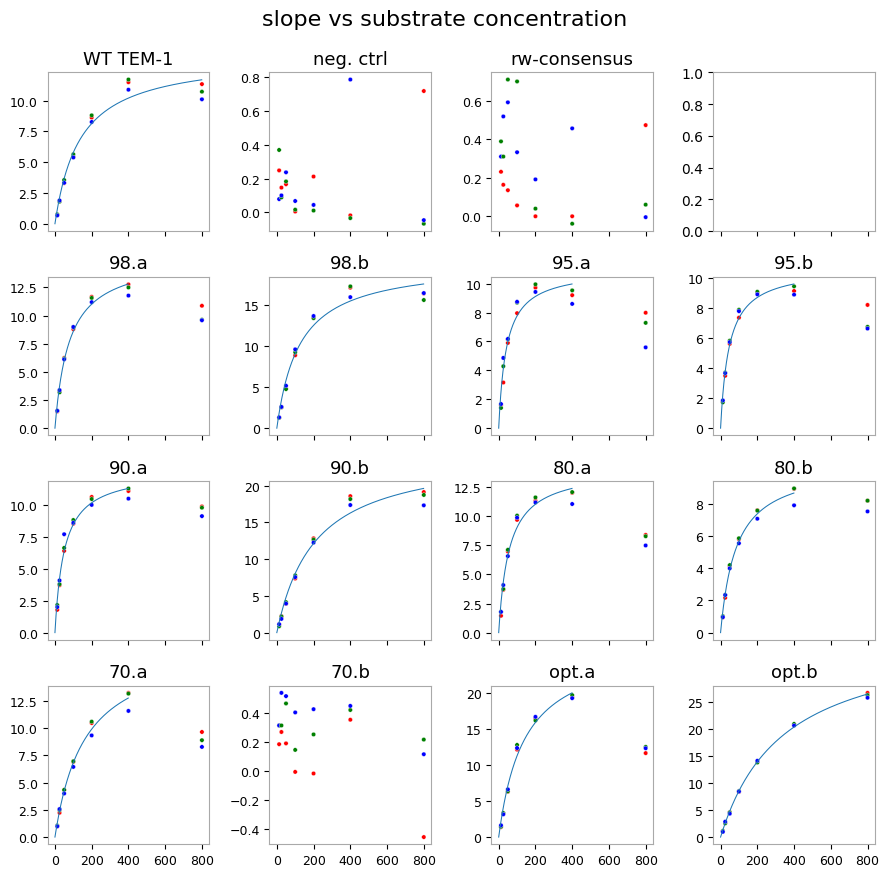

In [20]:
plot_parameter_fit(
    final_mm_parameters_df, 
    michaelis_menten_equation,
    filename_to_save=OUTPUT_DIR+'/mm_parameter_fit_to_data.pdf'
)

In [21]:
def get_paramfit_source_data():
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    return final_mm_parameters_df.assign(
        sort_manuscript_order = lambda df: df.manuscript_name.apply(
            lambda samplename: sample_order.index(samplename)
        )
    ).sort_values(
        by=['sort_manuscript_order']
    )[[
        'manuscript_name', 'max_substrate_conc', 
        'Km', 'Km_stderr', 
        'kcat', 'kcat_stderr', 
        'kcat_over_Km', 'kcat_over_Km_stderr',
    ]]
get_paramfit_source_data().to_csv(
    OUTPUT_DIR+'/param_fit.tab', sep ='\t', index=False
)

**Output final parameters as a barplot - displayed in main text**

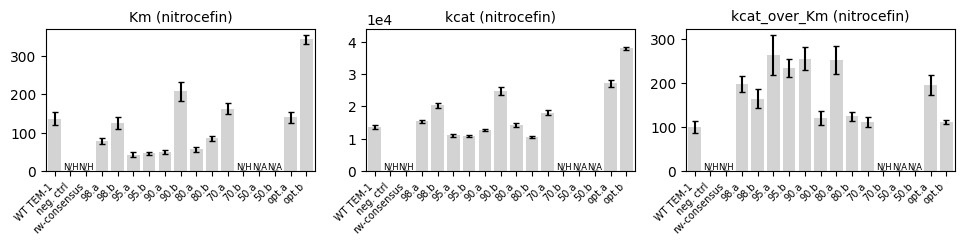

In [22]:
plot_kinetics(
    final_mm_parameters_df, 
    filename_to_save=OUTPUT_DIR+'/nitrocefin_biochemistry.pdf'
)

**Output final kinetics source data**

In [23]:
#output source data
def get_mm_source_data():
    source_df = final_mm_parameters_df[
        ~final_mm_parameters_df.manuscript_name.isin(
            ['50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus'] #no data samples
        )
    ]
    sample_order = FHS.get_sample_order(source_df.manuscript_name)
    return source_df.assign(
        sort_manuscript_order = lambda df: df.manuscript_name.apply(
            lambda samplename: sample_order.index(samplename)
        )
    ).sort_values(
        by='sort_manuscript_order'
    )[[
        'manuscript_name', 
        'Km', 'Km_stderr', 
        'kcat', 'kcat_stderr',
        'kcat_over_Km', 'kcat_over_Km_stderr'
    ]].rename(columns={
        'manuscript_name': 'Sample',
        'Km_stderr': 'Km (standard error)',
        'kcat_stderr': 'kcat (standard error)',
        'kcat_over_Km': 'kcat / Km',
        'kcat_over_Km_stderr': 'kcat / Km (standard error)',
    })
#sns.barplot(
#    get_mm_source_data(), x='Sample', y='kcat / Km'
#)
get_mm_source_data().to_csv(OUTPUT_DIR+'/mm_data.tab', sep ='\t', index=False)

**Output raw data as a table - displayed in supplementary table**

In [24]:
output_table(final_mm_parameters_df, latex=False)

,manuscript_name,max_substrate_conc,Km,Km_stderr,kcat,kcat_stderr,kcat_over_Km,kcat_over_Km_stderr,order
0,WT TEM-1,800.0,136.297650,17.587395,13689.175842,604.657786,100.435890,13.698180,0
1,neg. ctrl,400.0,0.001891,6.158133,150.386391,63.955265,79511.633453,0.000000,1
2,rw-consensus,400.0,0.003063,6.100535,282.294421,80.412501,92159.554241,0.000000,2
3,98.a,400.0,77.768953,6.688982,15306.910648,462.273515,196.825470,17.942391,3
4,98.b,800.0,123.948928,15.256953,20276.241469,831.904350,163.585453,21.224950,4
5,95.a,400.0,41.926672,6.800095,11026.300548,520.892589,262.990118,44.426934,5
6,95.b,400.0,46.095352,3.895888,10739.310633,272.014658,232.980339,20.556274,6
7,90.a,400.0,49.822641,4.838948,12664.685946,377.364787,254.195396,25.824058,7
8,90.b,800.0,207.044000,25.343032,24724.430902,1172.630286,119.416312,15.675944,8
9,80.a,400.0,56.351487,6.836675,14152.575411,546.647042,251.148216,31.976739,9


**Plot raw data and slopes selected for fitting to michaelis menten equation**

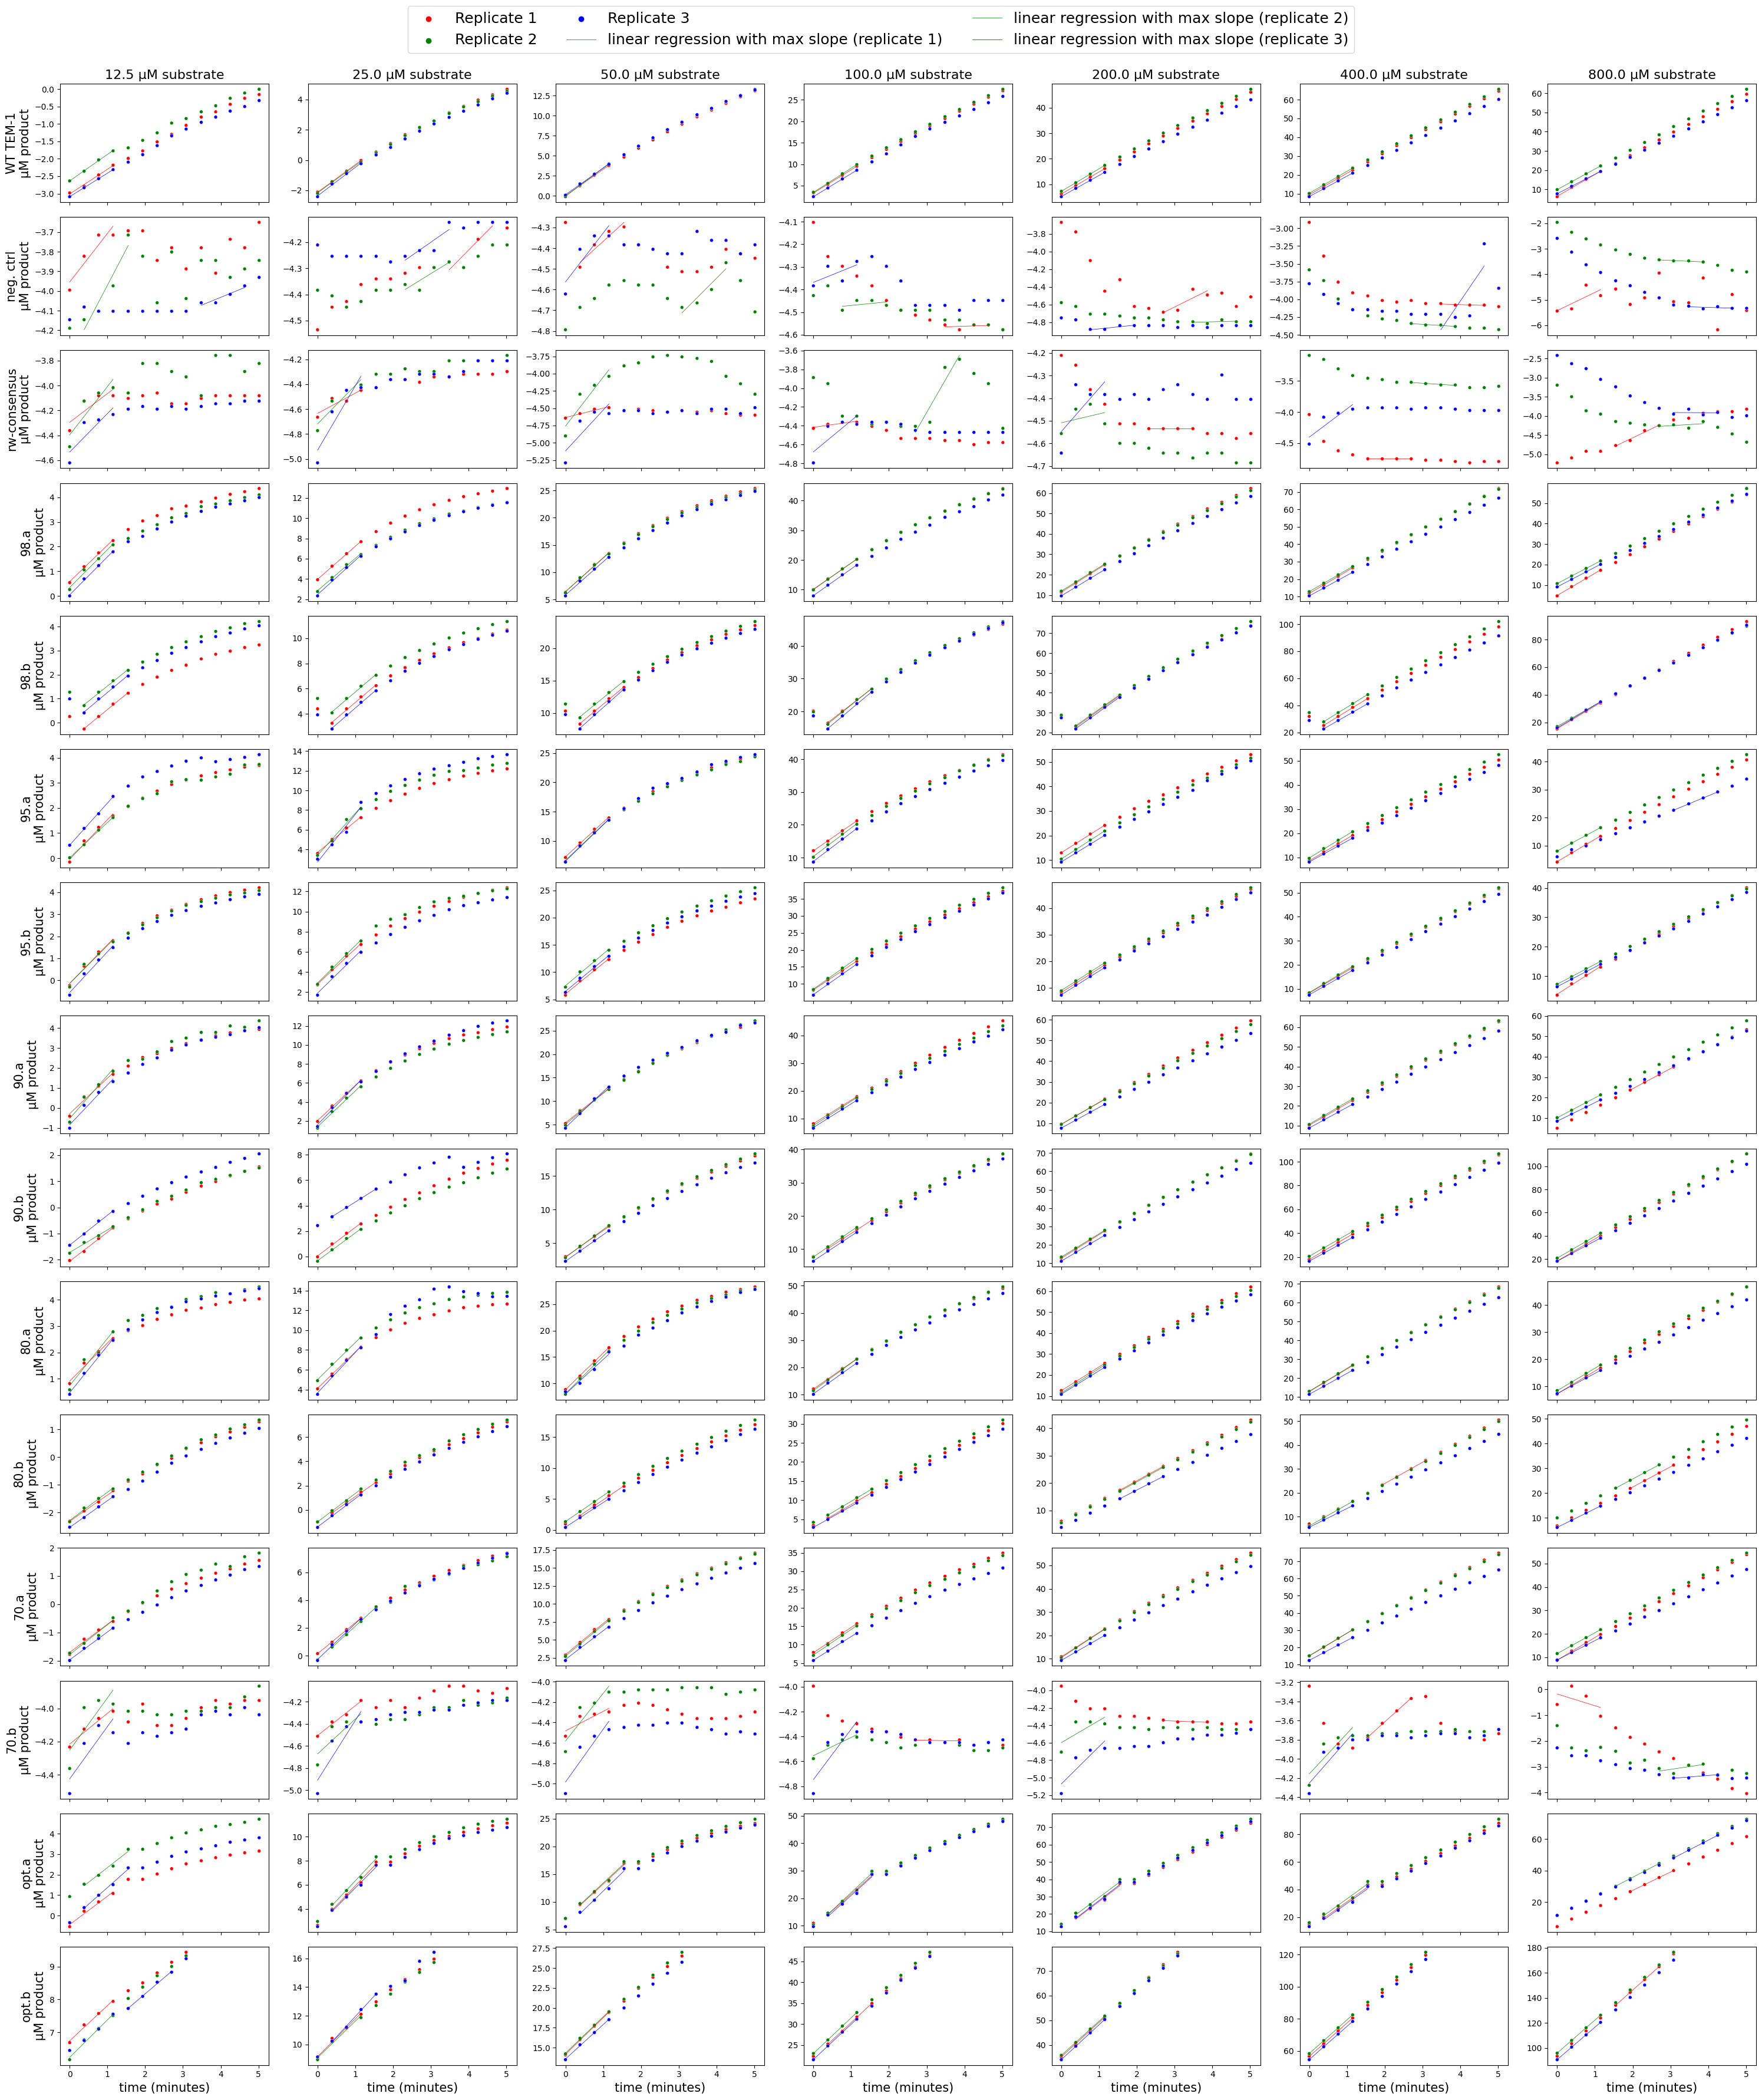

In [25]:
plot_best_slopes(
    filename_to_save=OUTPUT_DIR+'/best_slopes_fit_to_data.pdf'
)

**Output raw nitrocefin source data**

In [26]:
#output source data
def get_raw_source_data():
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    return narrow_df.assign(
        sort_manuscript_order = lambda df: df.manuscript_name.apply(
            lambda samplename: sample_order.index(samplename)
        )
    ).sort_values(
        by=['sort_manuscript_order', 'Rep', 'uM_substrate', 'time_min']
    )[[
        'manuscript_name', 'Rep', 'uM_substrate', 'time_min', 'uM_product'
    ]].rename(columns={
        'Rep': 'Rep #',
        'uM_substrate': 'uM Substrate',
        'time_min': 'Time (minutes)',
        'uM_product': 'uM Product',
    })
get_raw_source_data().to_csv(OUTPUT_DIR+'/raw_nitrocefin_data.tab', sep ='\t', index=False)

In [27]:
def get_final_slopes_source_data():
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    return final_slopes_df.assign(
        sort_manuscript_order = lambda df: df.manuscript_name.apply(
            lambda samplename: sample_order.index(samplename)
        )
    ).sort_values(
        by=['sort_manuscript_order', 'rep_num', 'uM_substrate']
    )[[
        'manuscript_name', 'rep_num', 'uM_substrate', 
        'slope', 'intercept', 'window_time_mins'
    ]].rename(columns={
        'manuscript_name': 'Sample',
        'rep_num': 'Rep #',
        'uM_substrate': 'uM Substrate',
        'slope': 'Slope',
        'intercept': 'Intercept',
        'window_time_mins': 'Initial Rate Window Times (minutes)'
    })
get_final_slopes_source_data().to_csv(
    OUTPUT_DIR+'/final_slopes.tab', sep ='\t', index=False
)

## Analysis - Michaelis-Menten equation with Inhibition

In [28]:
#some of the samples clearly have inhibition at the highest substrate 
#concentration (800uM), so check how well the Michaelis-Menten equation 
#with Inhibition fits the data
def michaelis_menten_inhibition_equation(S,E,Km,kcat,Ki):
    return kcat*E*S/(Km + S*(1+S/Ki))

def get_michaelis_menten_inhibition_parameters():
    toreturn = {
        'manuscript_name': [],
        'max_substrate_conc': [],
        'Km': [],
        'kcat': [],
        'kcat_over_Km': [],
        'Ki': [],
        'Km_stderr': [],
        'kcat_stderr': [],
        'Ki_stderr': [],
        'kcat_over_Km_stderr': []
    }

    enzyme_conc=.001 #Enzyme conc = 1nM = .001uM

    for name in final_slopes_df.manuscript_name.unique():
        data = final_slopes_df[(
            (final_slopes_df.manuscript_name == name)
        )]
        substrate_conc=data.uM_substrate #substrate conc in uM
        slopes=data.slope
        
        # Create and fit model
        mdl = Model(michaelis_menten_inhibition_equation)
        params = Parameters()
        params.add("E", value=enzyme_conc, vary=False)
        params.add("Km", value=1e-3,min=0, max=1e5, vary=True)
        params.add("Ki", value=1e-3,min=0, max=1e7, vary=True)
        params.add("kcat", value=1e5, min=0, max=1e9, vary=True)
        result = mdl.fit(
            slopes,
            params=params,
            S=substrate_conc
        )
        toreturn['manuscript_name'].append(name)
        toreturn['Km'].append(result.params['Km'].value)
        toreturn['Km_stderr'].append(result.params['Km'].stderr)
        toreturn['kcat'].append(result.params['kcat'].value)
        toreturn['kcat_stderr'].append(result.params['kcat'].stderr)
        toreturn['Ki'].append(result.params['Ki'].value)
        toreturn['Ki_stderr'].append(result.params['Ki'].stderr)
        toreturn['kcat_over_Km'].append(
            result.params['kcat'].value / result.params['Km'].value
        )
        toreturn['max_substrate_conc'].append(800)
        
        if name in ['50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus']:
            toreturn['kcat_over_Km_stderr'].append(0)
        else: 
            toreturn['kcat_over_Km_stderr'].append(
                get_kcat_over_Km_stderr(
                    result.params['kcat'].value,
                    result.params['kcat'].stderr,
                    result.params['Km'].value,
                    result.params['Km'].stderr,
                )
            )
    return pd.DataFrame(toreturn)

final_mmi_parameters_df = get_michaelis_menten_inhibition_parameters()

In [29]:
# check errors
get_errors_as_percentage(final_mmi_parameters_df)

,manuscript_name,Km_stderr_percent,kcat_stderr_percent,kcat_over_Km_stderr_percent,Ki_stderr_percent
0,70.a,109.988506,123.415833,165.314668,129.899752
1,70.b,1694.401489,1259.304005,0.000000,1201.818505
2,80.a,14.373104,31.398654,34.532037,37.664454
3,80.b,38.124699,70.868563,80.472641,81.413257
4,90.a,27.610552,60.914224,66.879633,71.246015
5,90.b,12.412108,22.880301,26.030148,28.141853
6,95.a,9575.362688,1022.589086,9629.810956,1015.162065
7,95.b,92031.574844,84196.396773,124735.095294,83065.212340
8,98.a,38.199974,74.344922,83.584720,81.766329
9,98.b,4.965202,14.118573,14.966207,19.751999


```
In general, errors almost are much higher than fitting the standard Michaelis Menten equation (i.e., without inhibition). However, for 98.b and opt.a, the inhibition equation fits the data well. Note that we report only the standard Michaelis Menten equation in the main text.
```

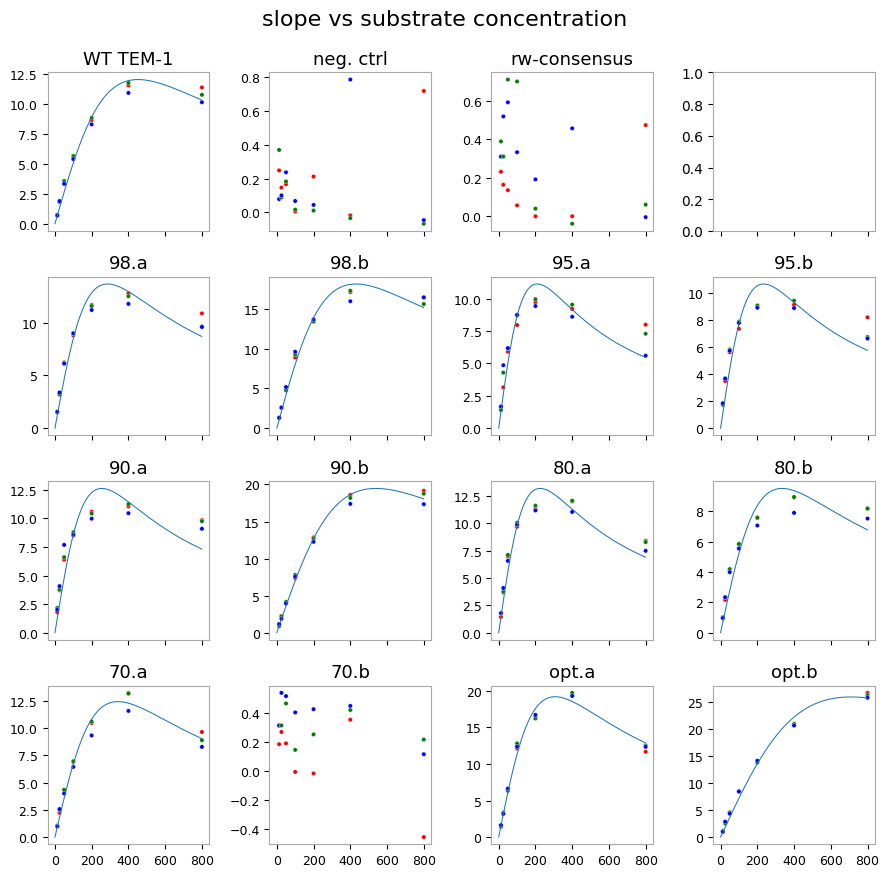

In [30]:
#Plot fit
plot_parameter_fit(final_mmi_parameters_df, michaelis_menten_inhibition_equation)

#### Raw Michaelis Menten Inhibition parameters:

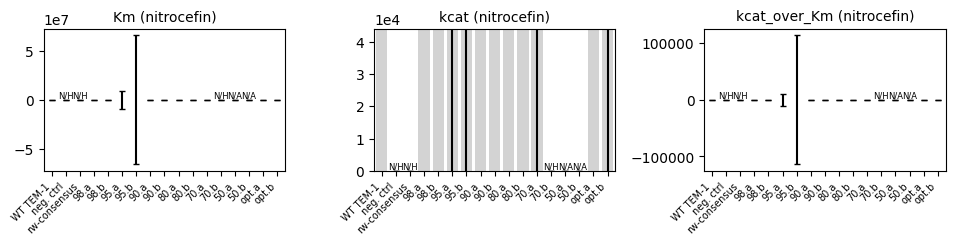

In [31]:
# Plot data - outlier samples obscure most data
plot_kinetics(
    final_mmi_parameters_df[
        ~final_mmi_parameters_df.manuscript_name.isin([
            '50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus'
        ])
    ],
)

#### Michaelis Menten Inhibition parameters without samples that had the highest standard errors:

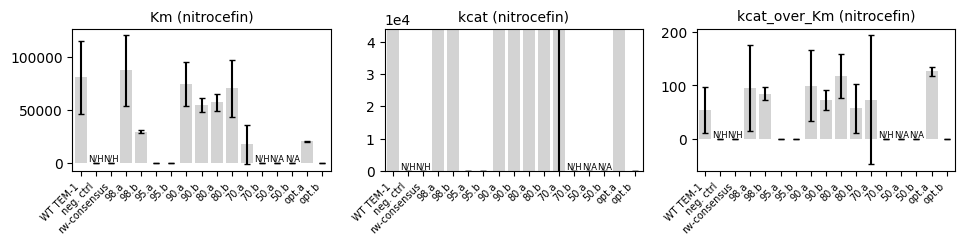

In [32]:
# Plot data - remove samples with the worst errors
plot_kinetics(
    final_mmi_parameters_df[
        ~final_mmi_parameters_df.manuscript_name.isin([
            '50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus'
        ])
    ],
    ignored_samples=['95.a', '95.b', 'opt.b']
)


#### Michaelis Menten Inhibition parameters with only samples with very low standard errors:

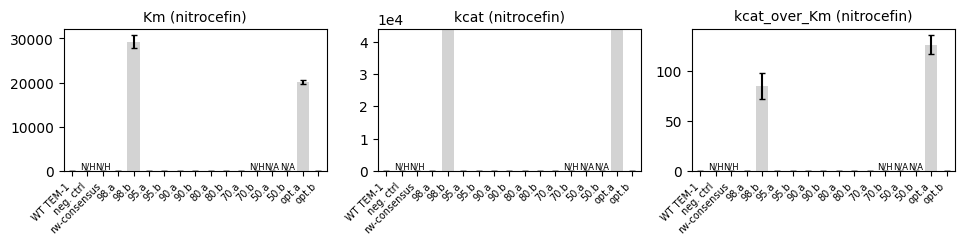

In [33]:
# Plot data - remove all but the samples with reasonable standard errors
plot_kinetics(
    final_mmi_parameters_df[
        ~final_mmi_parameters_df.manuscript_name.isin([
            '50.a', '50.b', '70.b', 'neg. ctrl', 'rw-consensus'
        ])
    ],
    ignored_samples=[
        'WT TEM-1', '98.a', '95.a', '95.b', 
        '90.a', '90.b', '80.a', '80.b', 
        'opt.b', '70.a'
    ]
)

## Misc plotting analysis

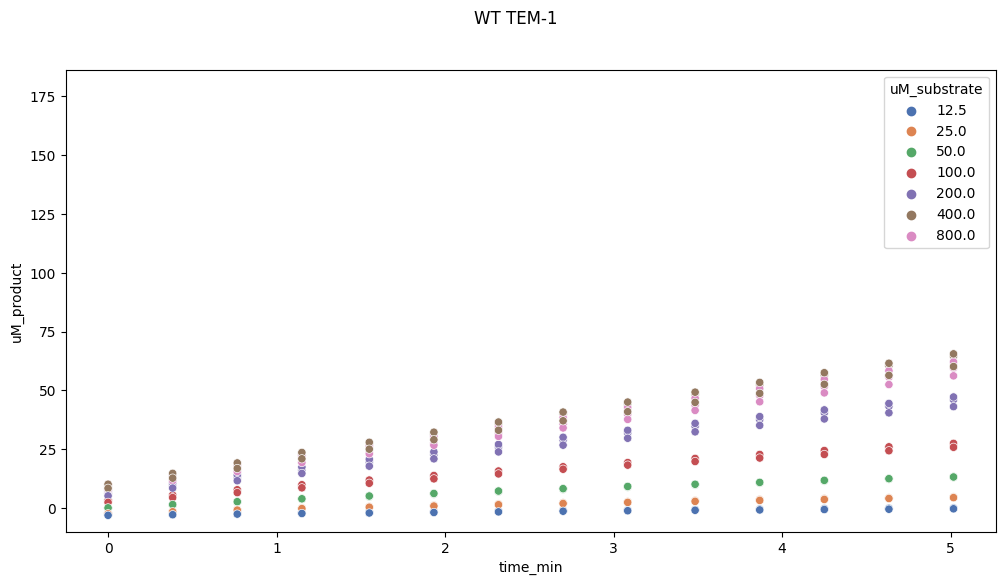

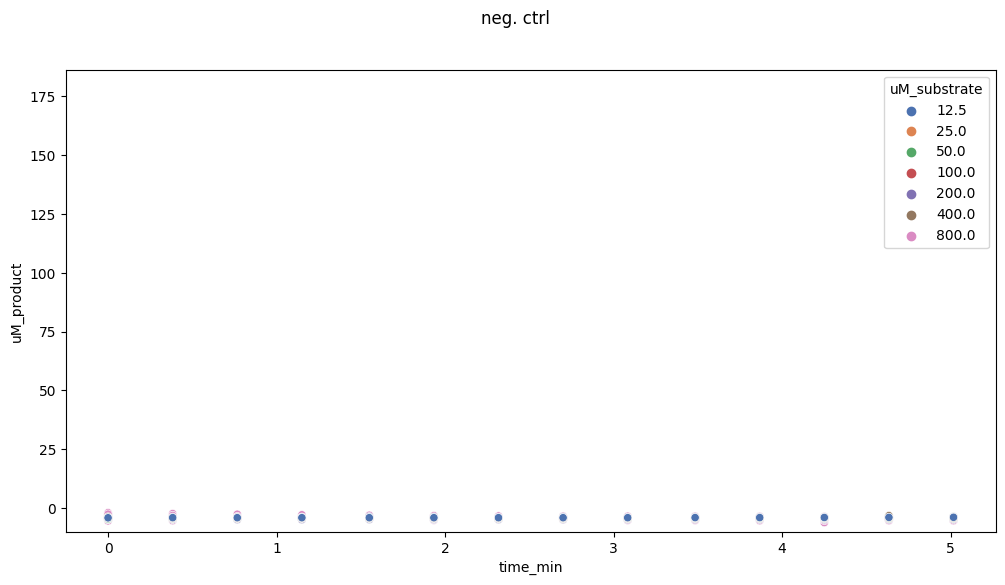

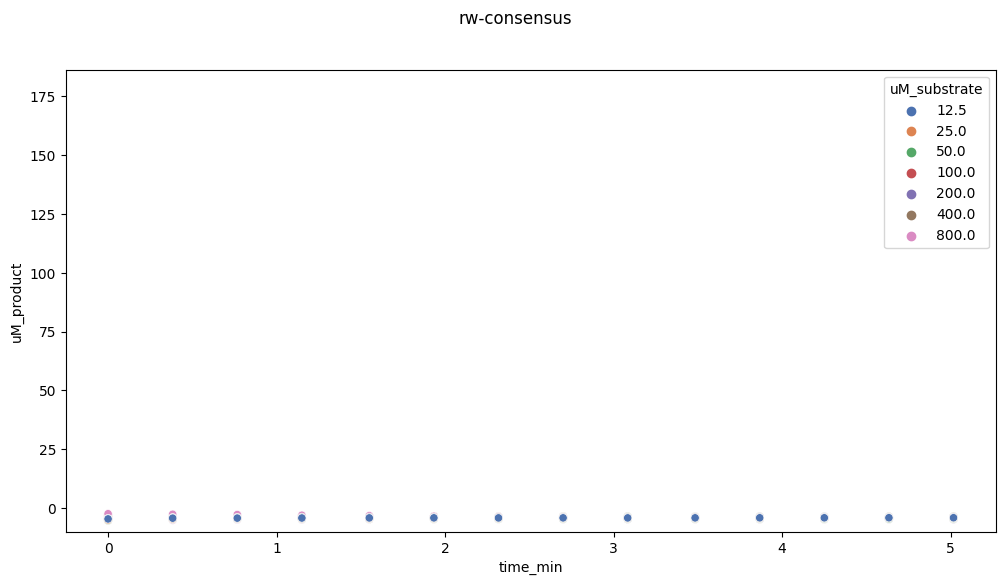

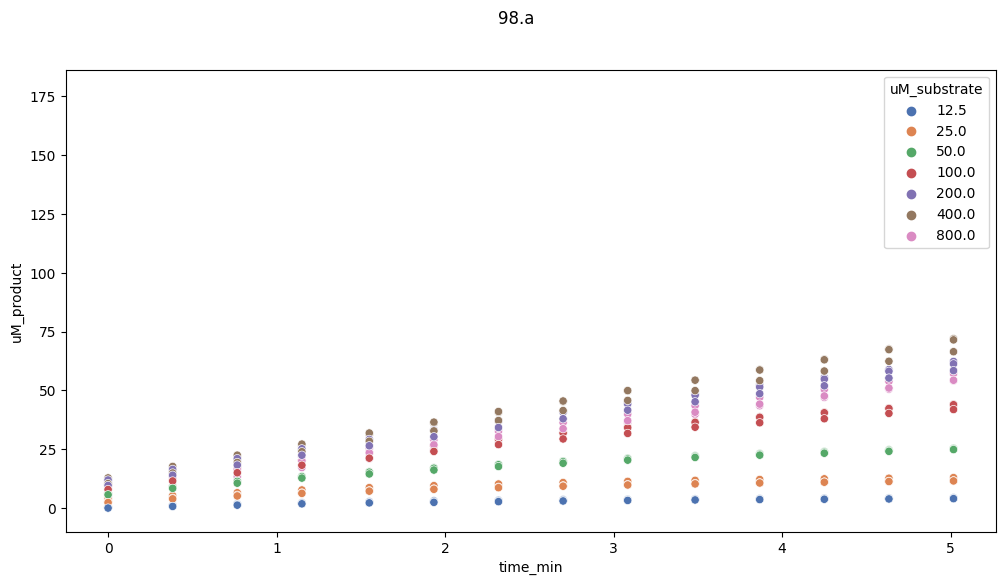

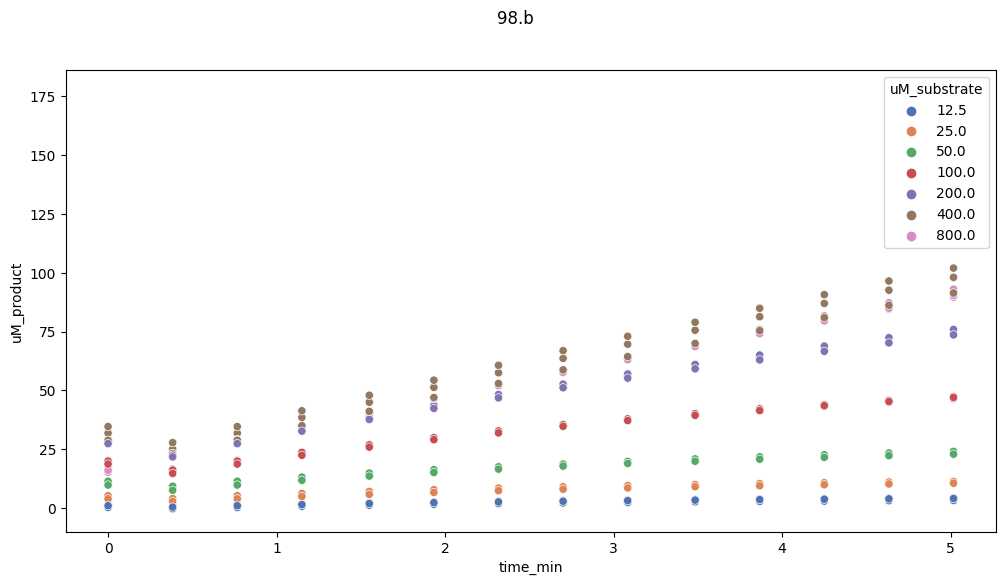

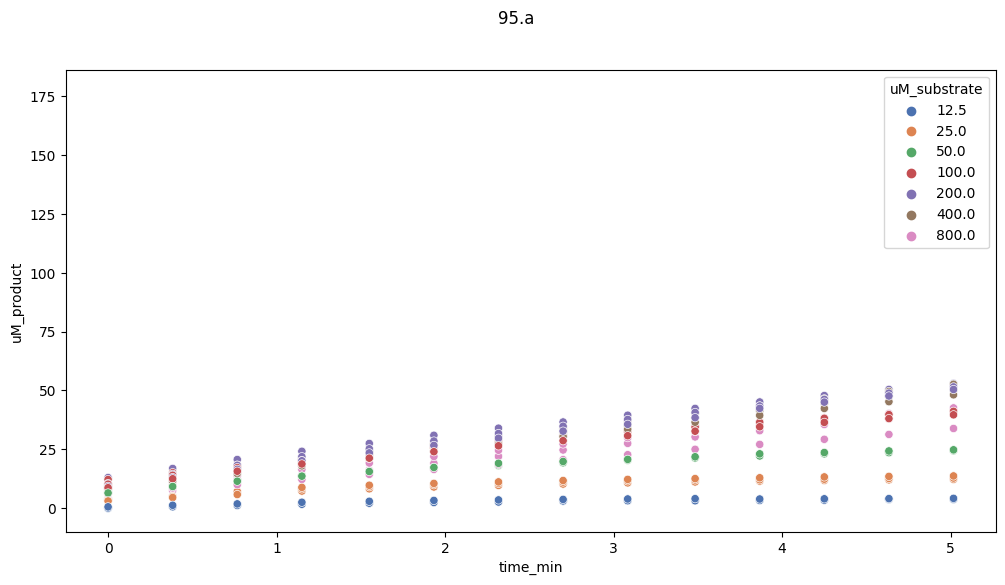

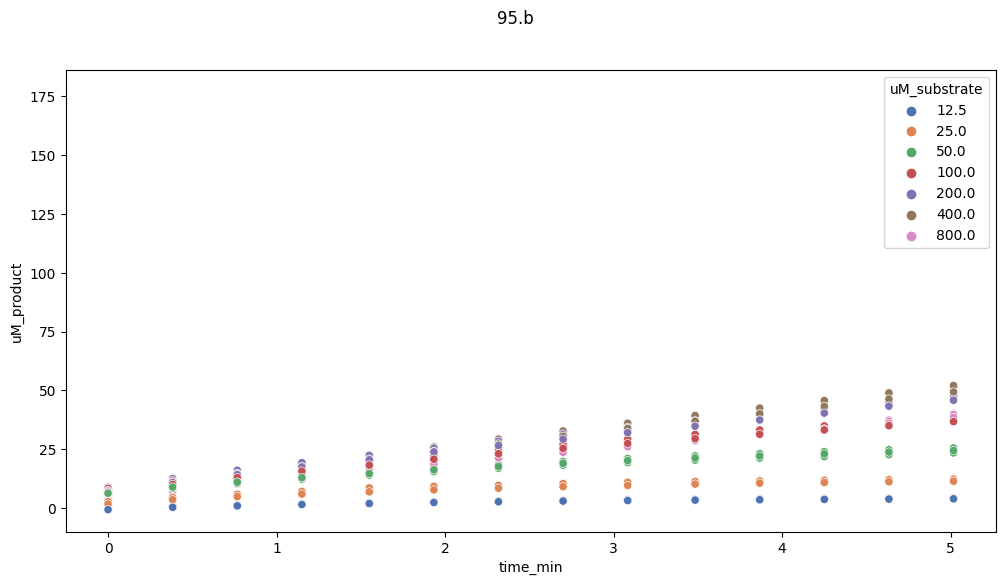

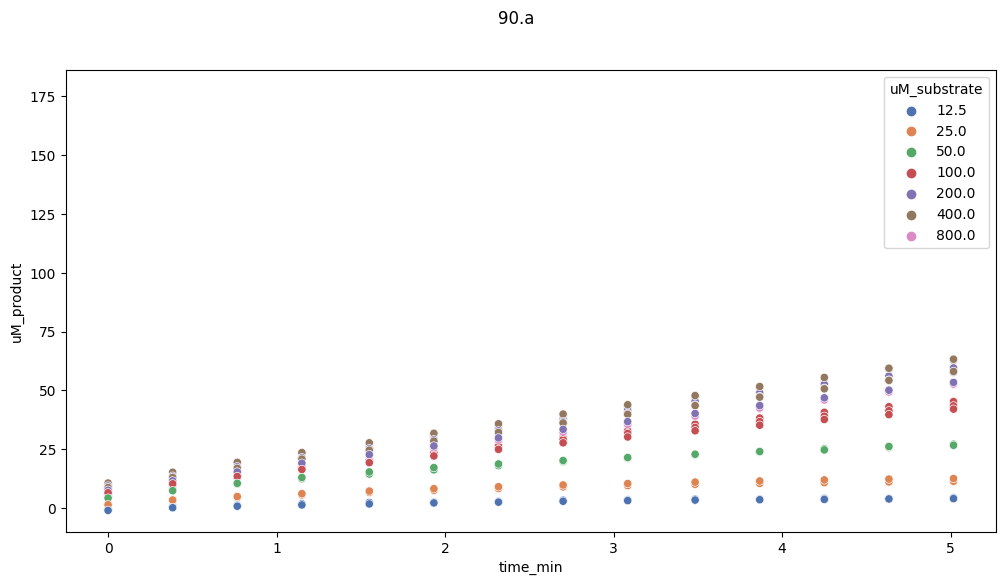

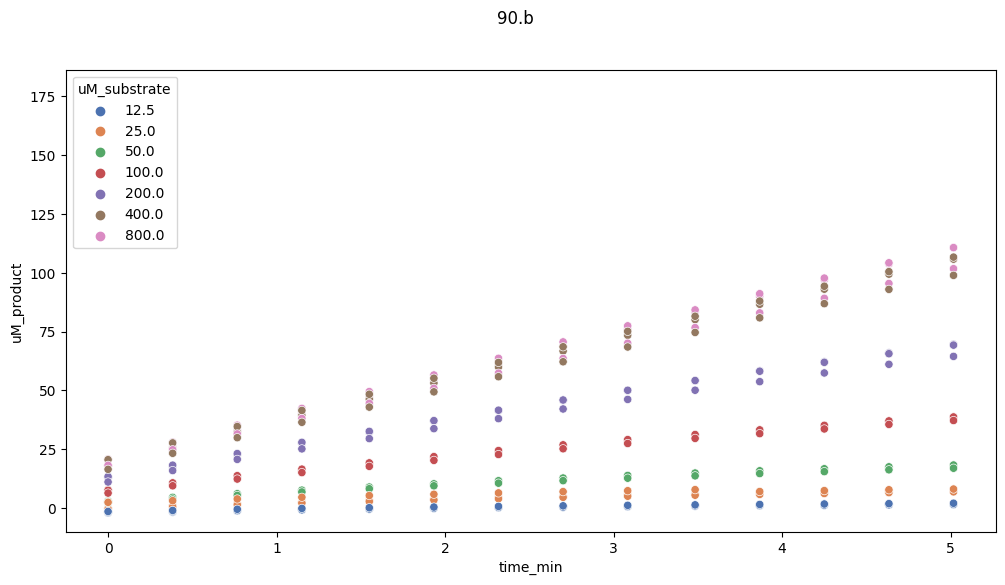

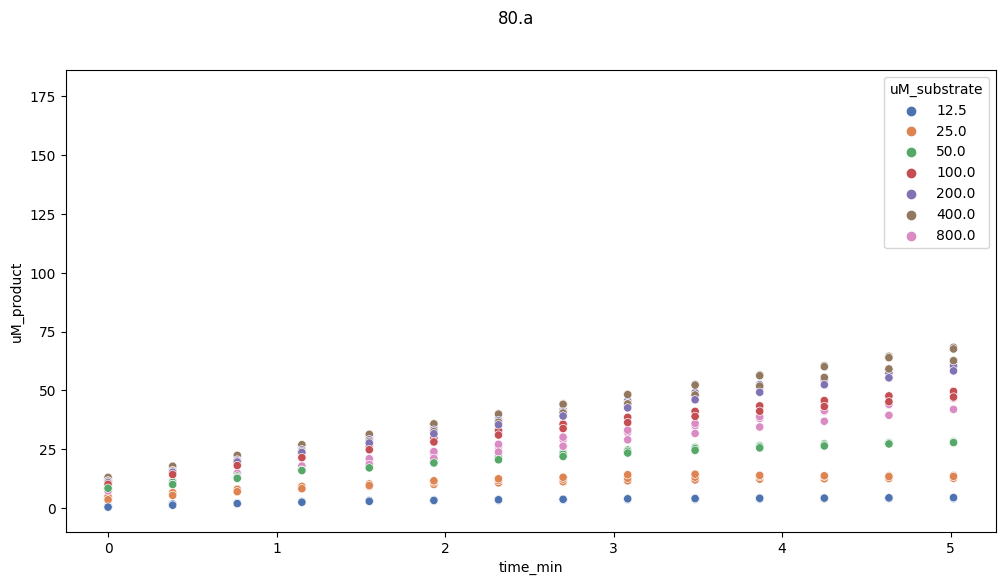

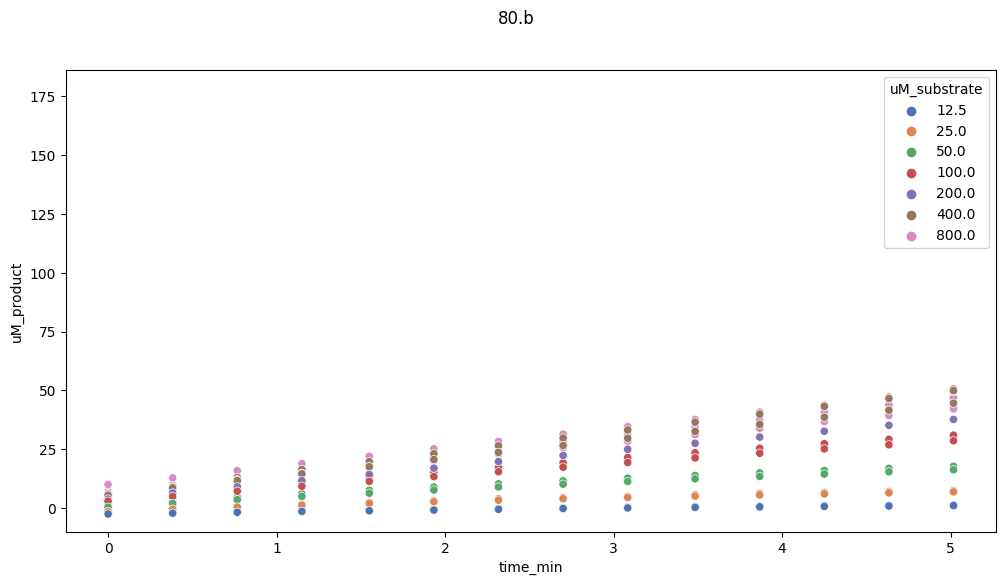

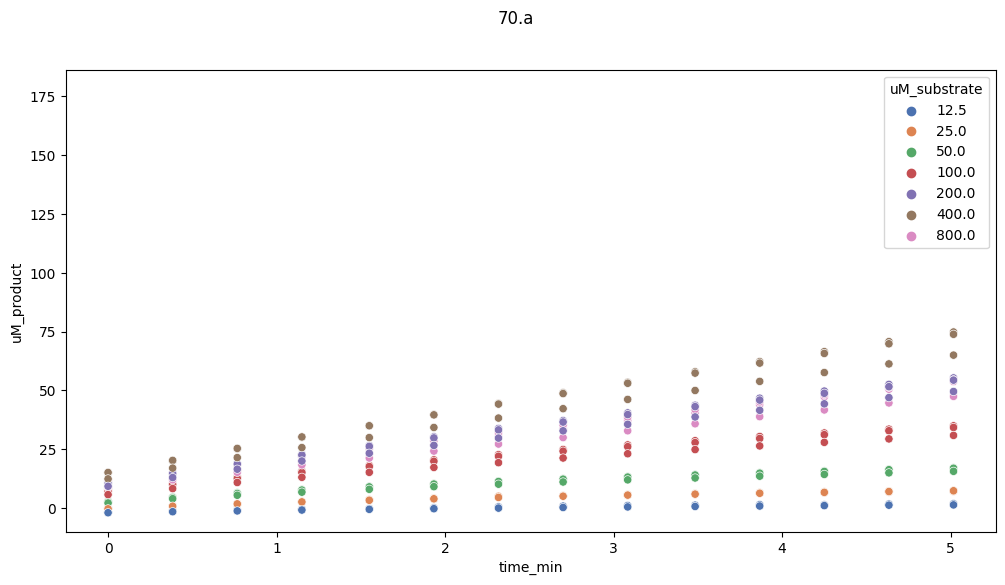

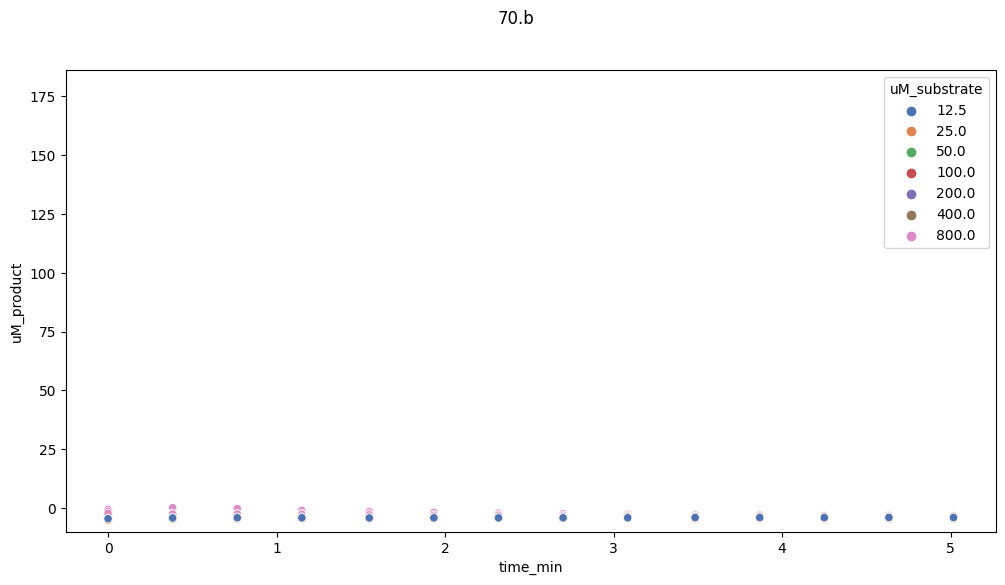

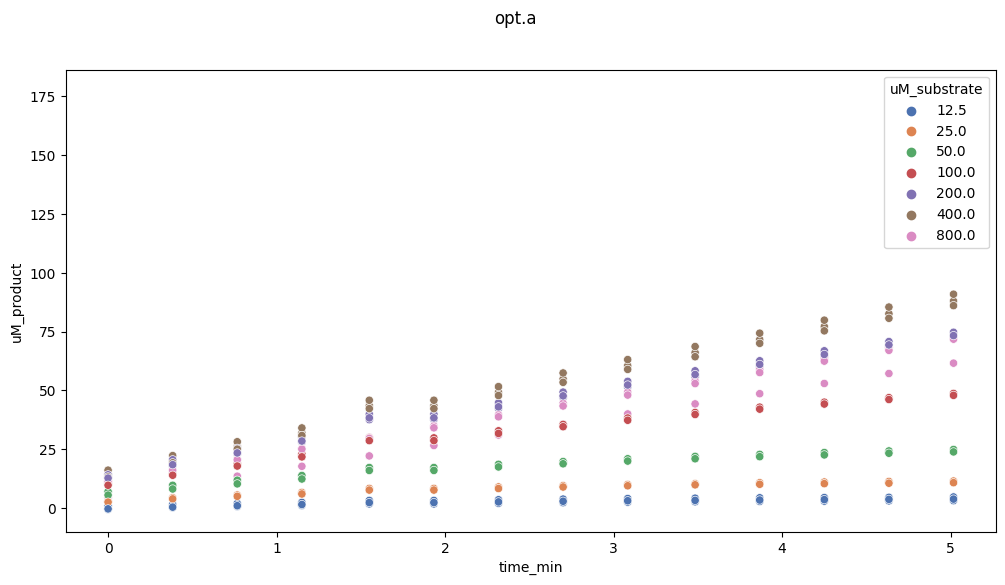

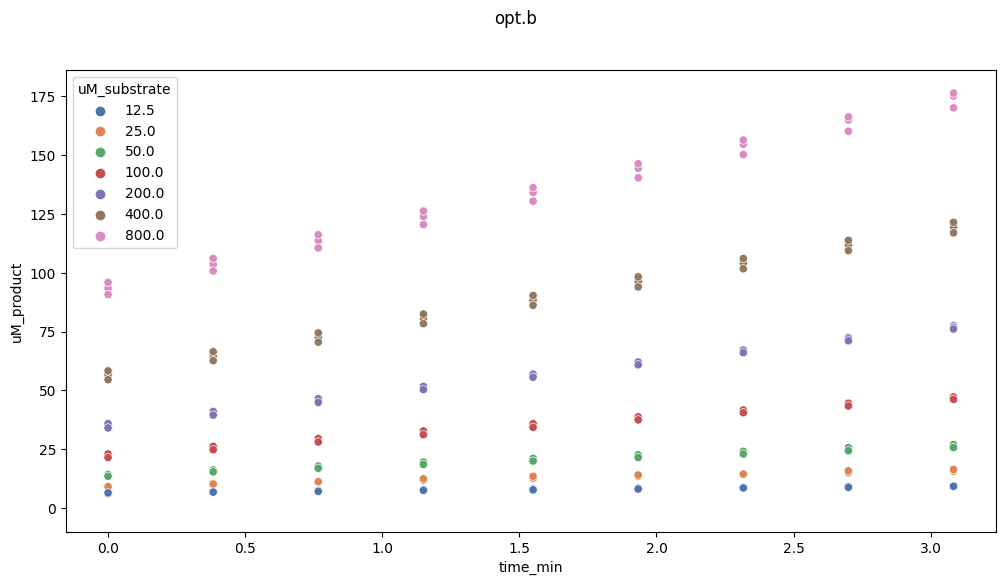

In [34]:
#plot all raw absorbance-determined uM concentrations
def plot_raw_data():
    sample_order = FHS.get_sample_order(narrow_df.manuscript_name)
    for manuscript_name in sample_order:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.suptitle(manuscript_name)
        fig.set_size_inches(12, 6)
        ax.set_ylim(-10, 10+ np.max(narrow_df['uM_product']))
        
        sns.scatterplot( 
            data=narrow_df[narrow_df['manuscript_name'] == manuscript_name],
            x='time_min', 
            y='uM_product', 
            hue='uM_substrate',#data['uM_product'],
            palette='deep',
            ax = ax,
        )
plot_raw_data()

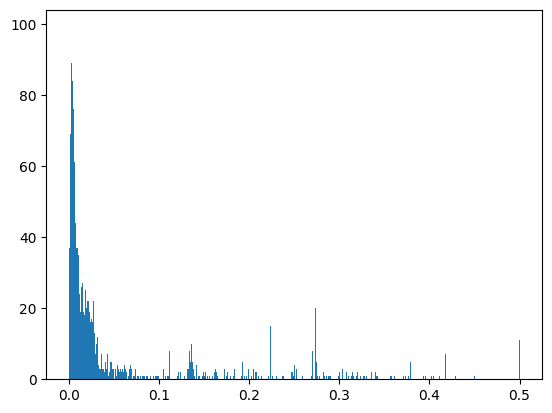

In [35]:
def plot_all_normalized_rmsd():
    plt.hist(
        x=linregress_df[linregress_df.nrmsd.apply(lambda x: isinstance(x, float))].nrmsd,
        bins=1000 #hue='uM_substrate', bins=500 
    )
plot_all_normalized_rmsd()

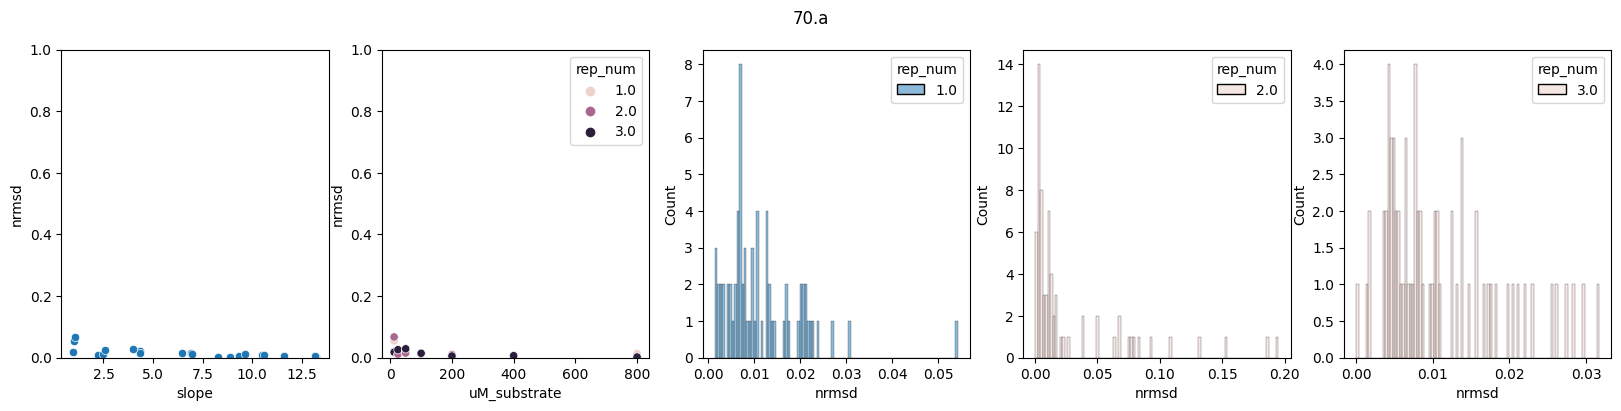

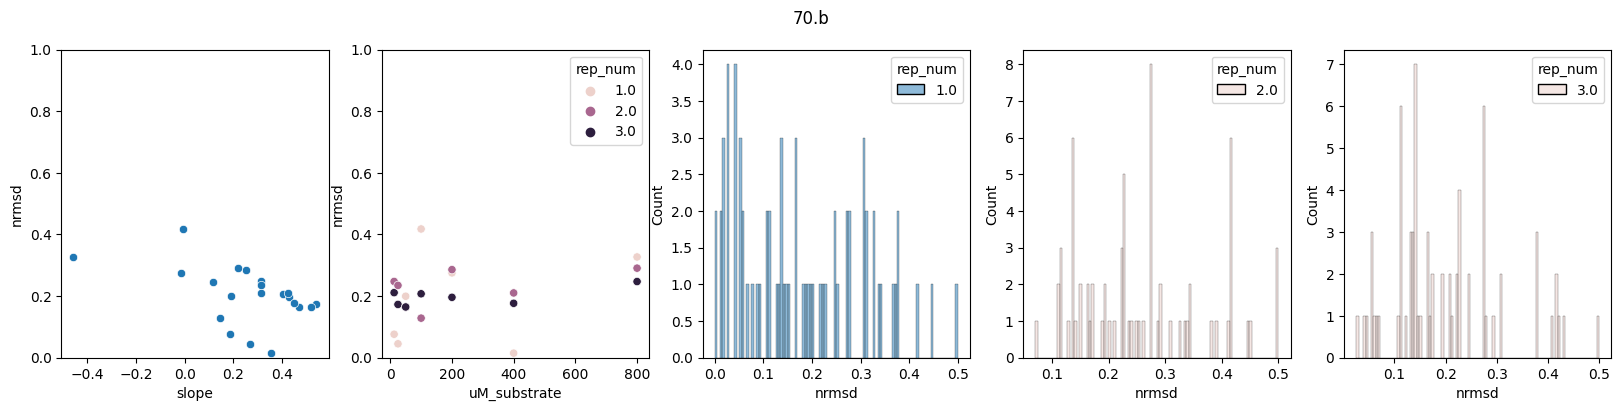

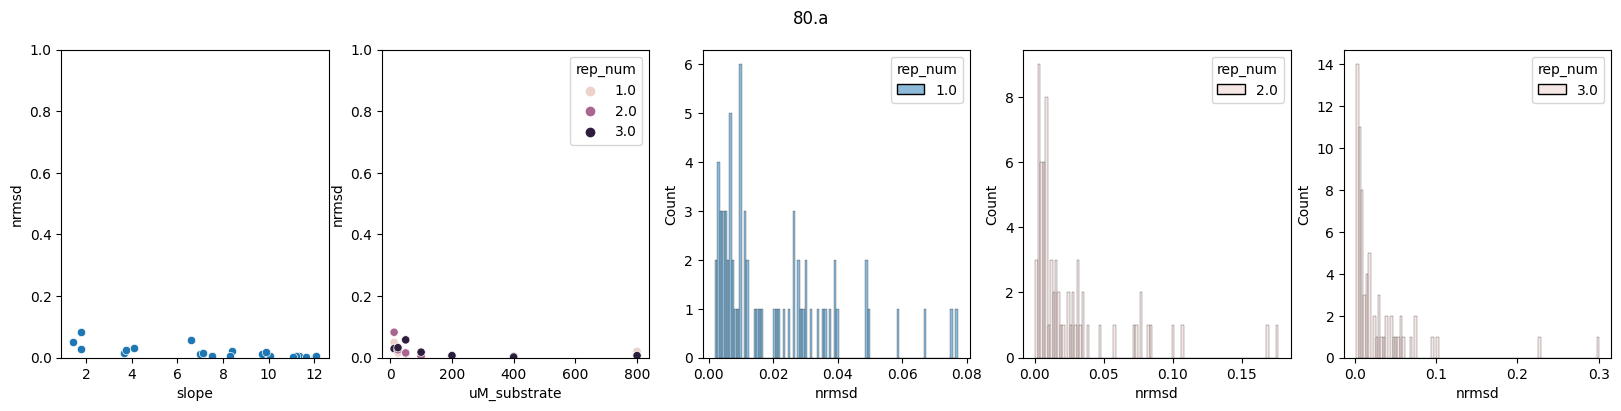

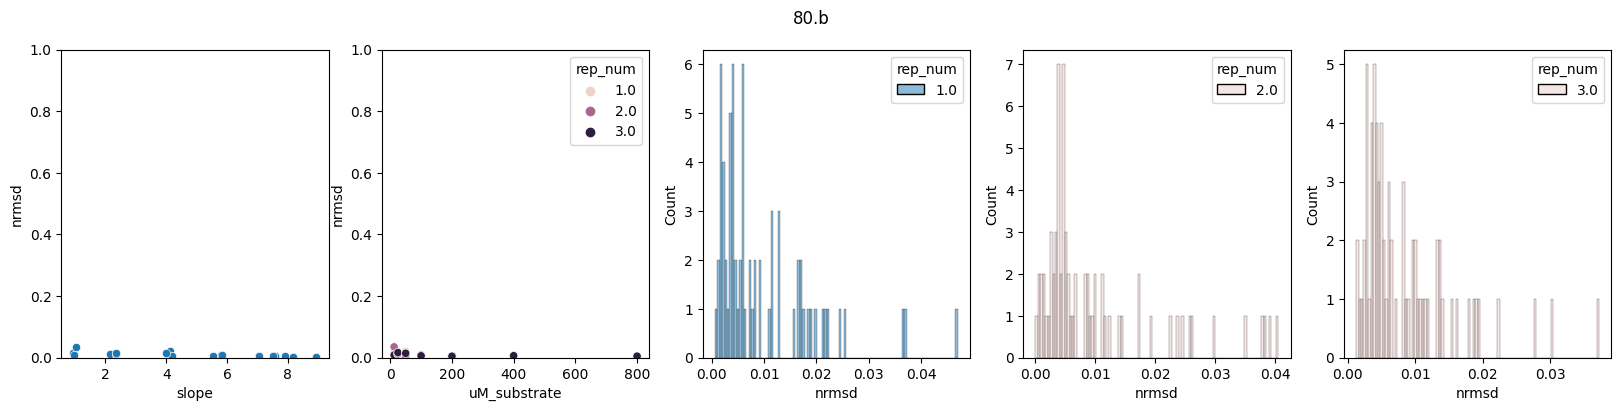

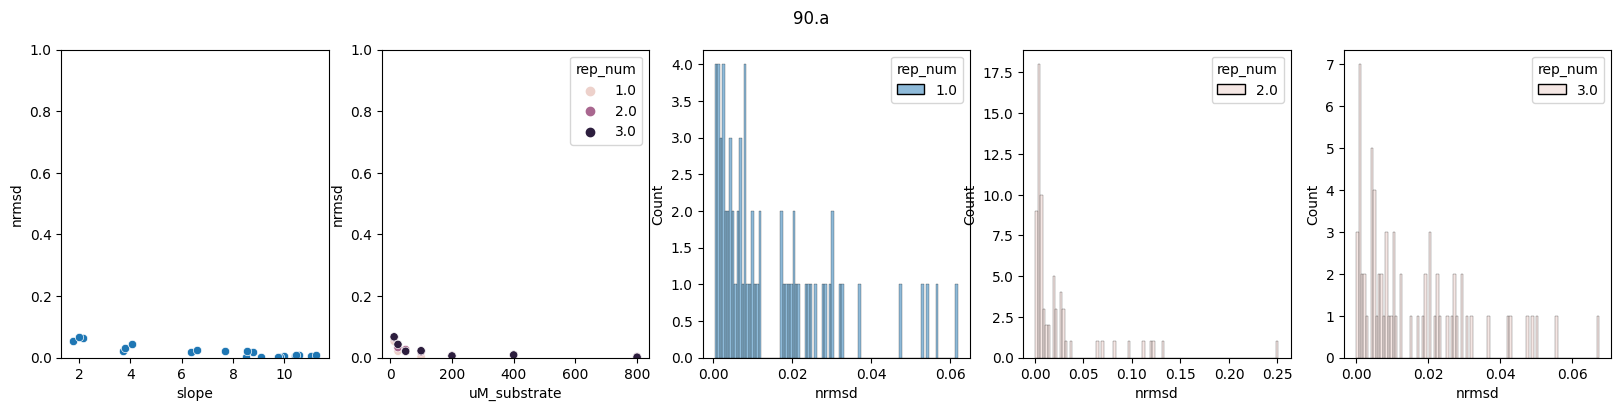

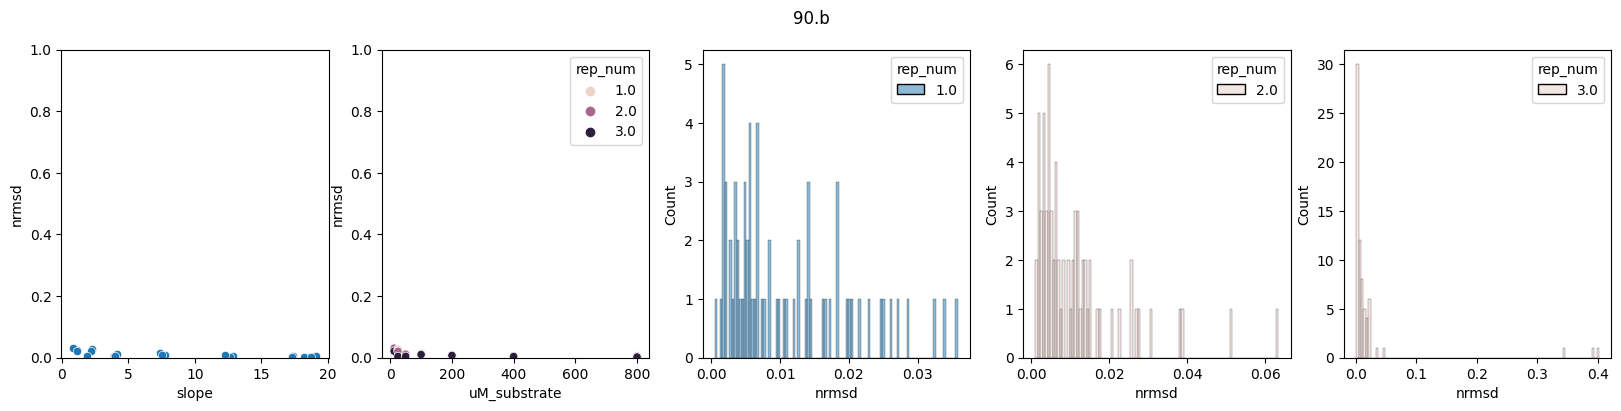

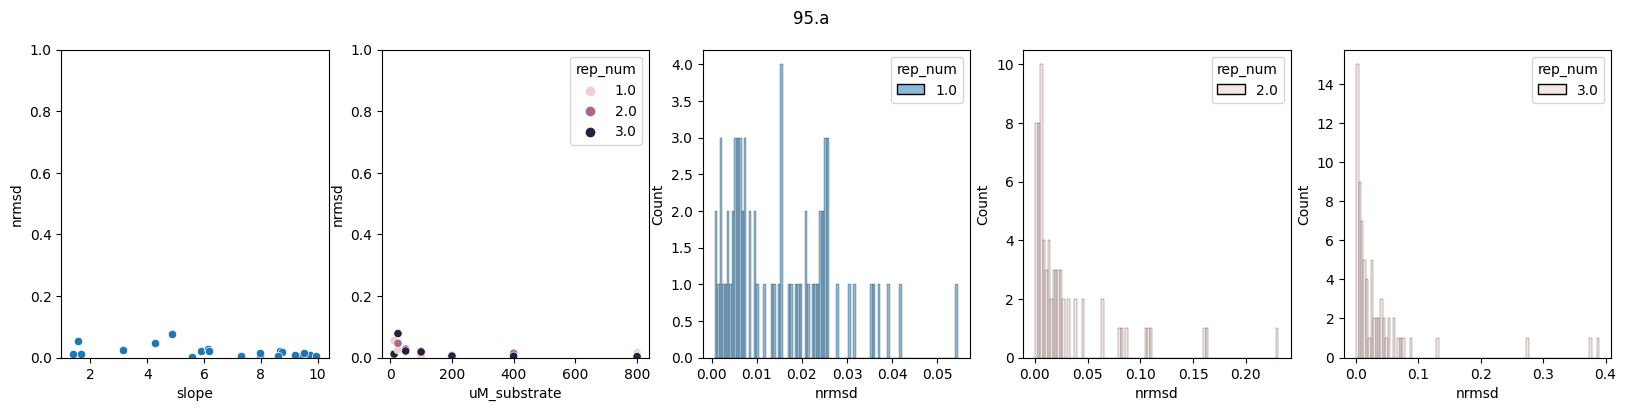

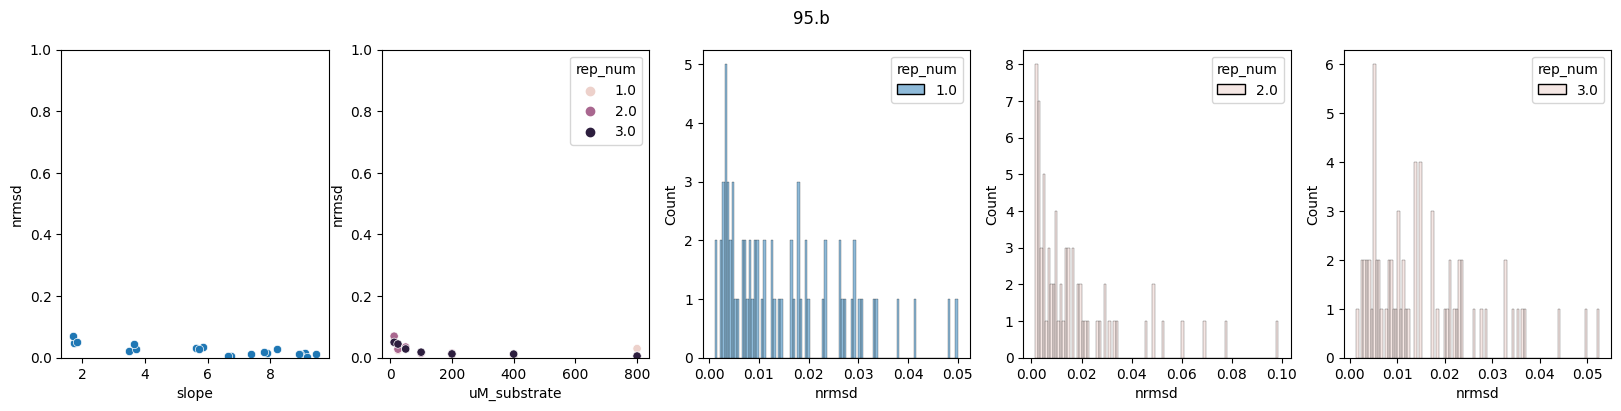

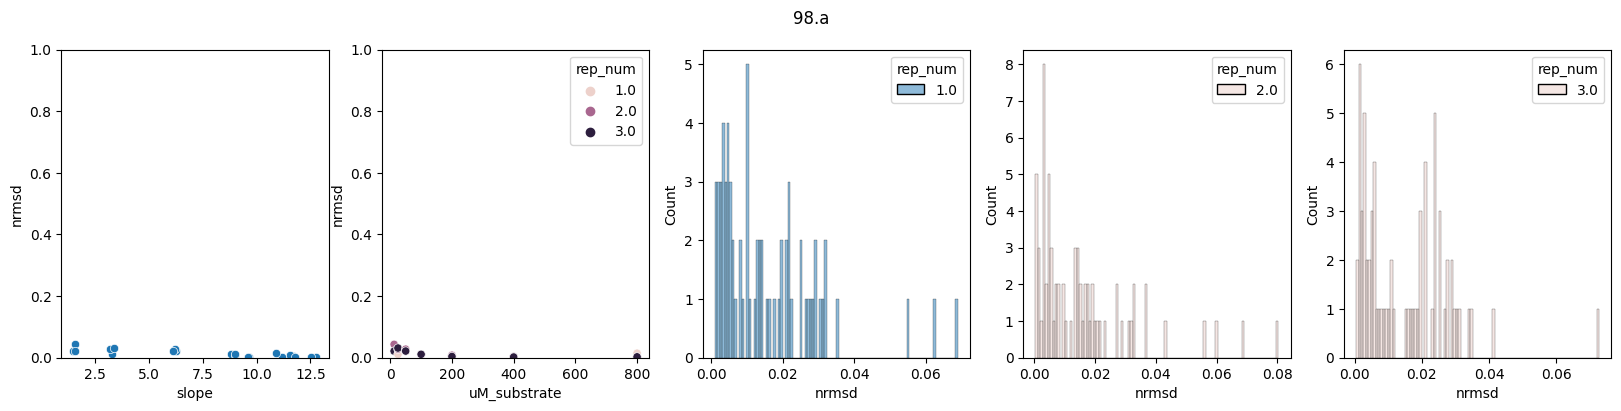

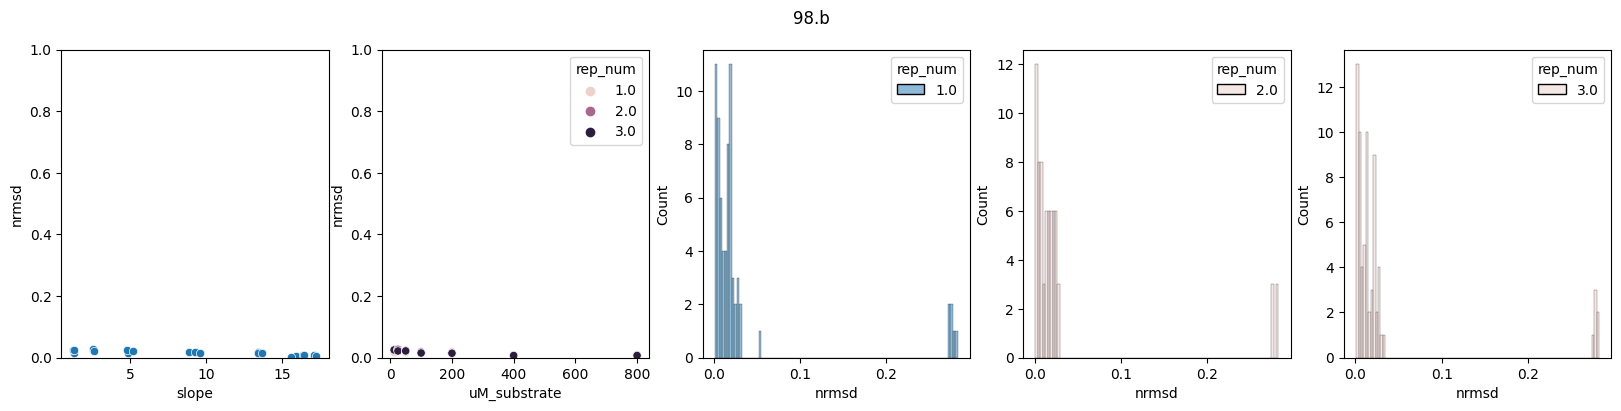

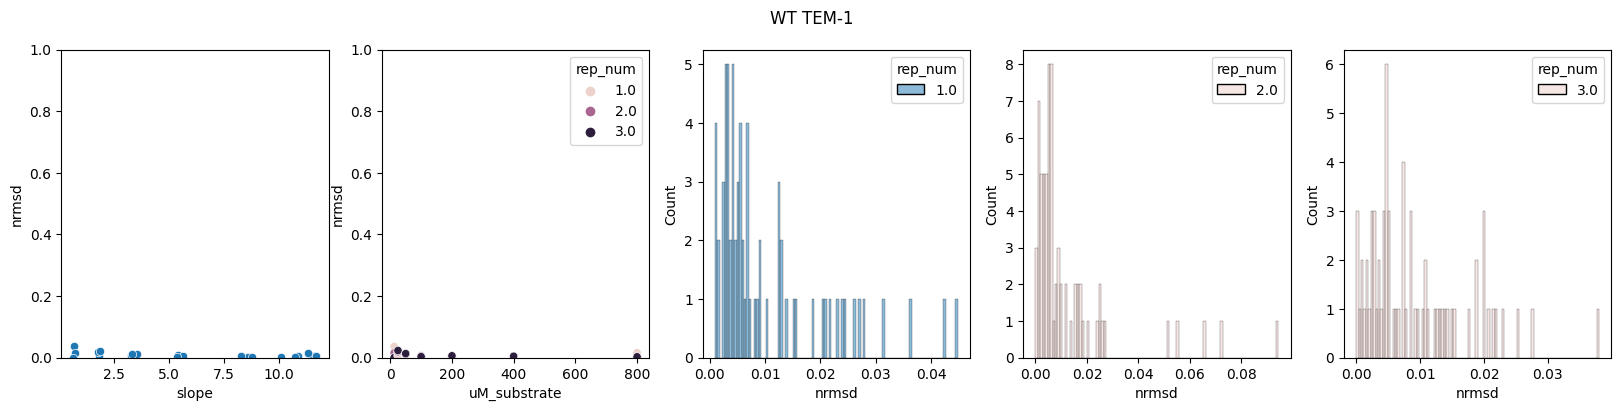

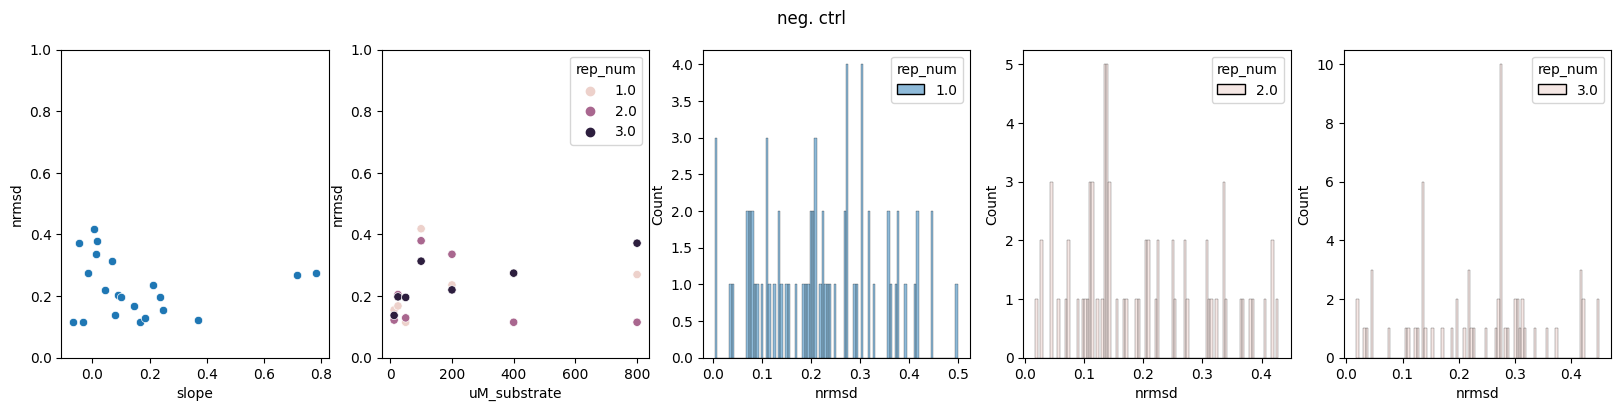

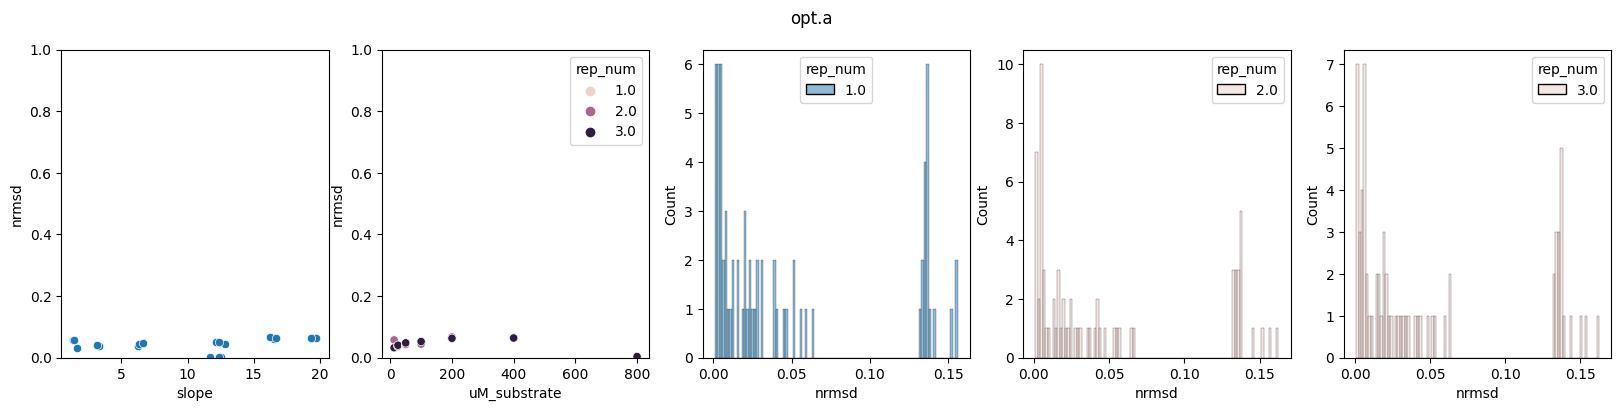

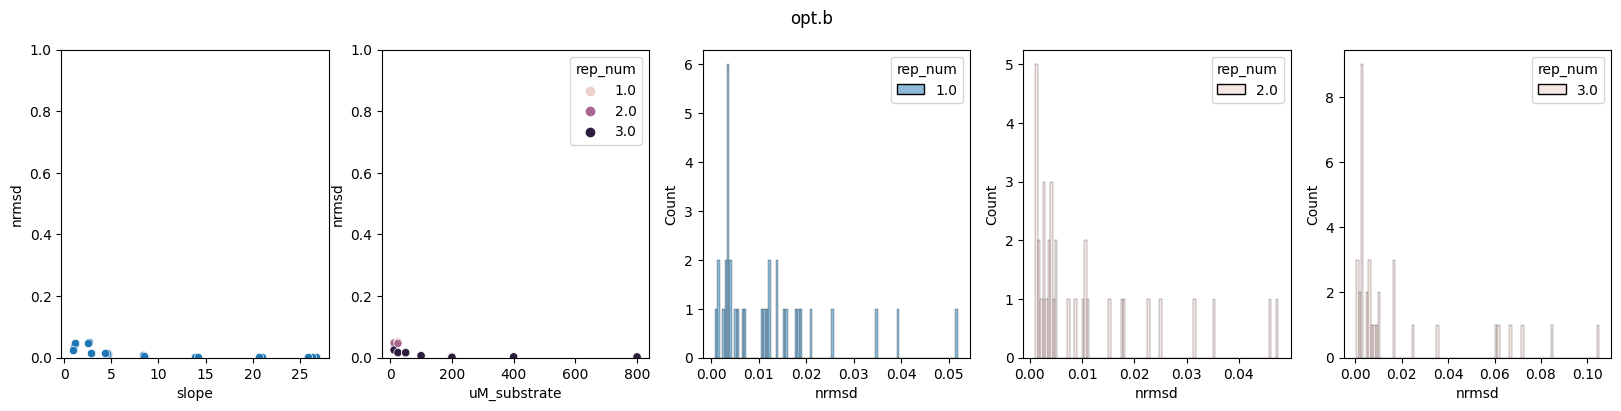

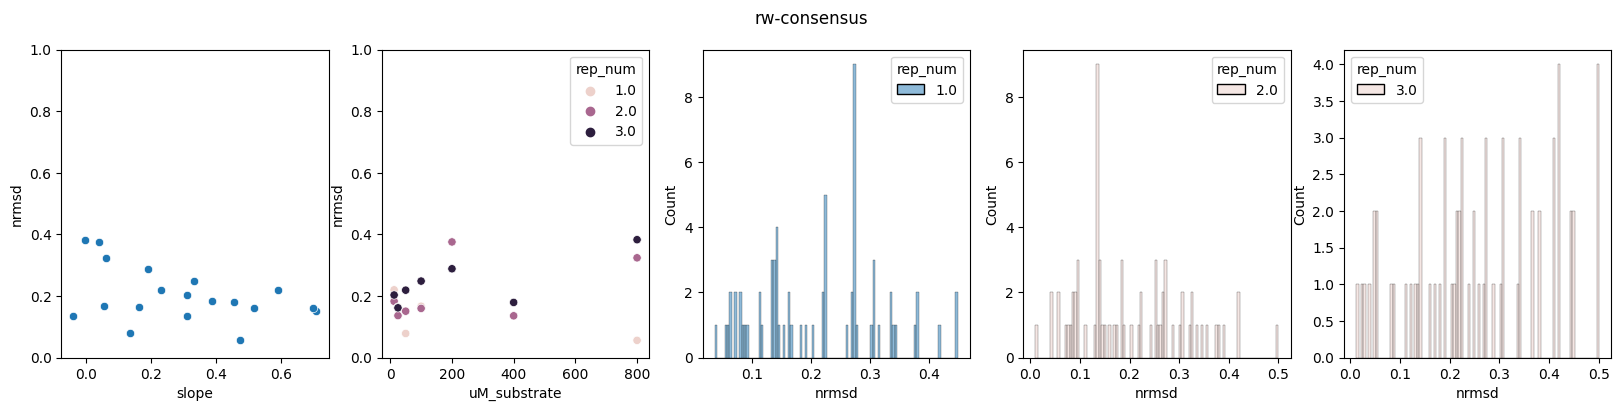

In [36]:
#sanity check plotting to check RMSDs
def plot_final_rmsds():
    for manuscript_name in linregress_df.manuscript_name.unique():
        fig, axes = plt.subplots(nrows=1, ncols=5)
        fig.suptitle(manuscript_name)
        fig.set_size_inches(20, 4)

        data_slopes = final_slopes_df[
            final_slopes_df.manuscript_name.isin([manuscript_name])
        ]
        data_all = linregress_df[(
            (linregress_df.manuscript_name==manuscript_name) &
            (linregress_df.rep_num==1)
        )]

        sns.scatterplot(
            data=data_slopes, 
            x='slope', y='nrmsd', ax=axes[0]
        )
        sns.scatterplot(
            data=data_slopes, 
            x='uM_substrate', y='nrmsd', hue='rep_num', ax=axes[1]
        )
        sns.histplot(
            data=linregress_df[(
                (linregress_df.manuscript_name==manuscript_name) &
                (linregress_df.rep_num==1)
            )], 
            x='nrmsd', hue='rep_num', ax=axes[2], bins=100
        )
        sns.histplot(
            data=linregress_df[(
                (linregress_df.manuscript_name==manuscript_name) &
                (linregress_df.rep_num==2)
            )], 
            x='nrmsd', hue='rep_num', ax=axes[3], bins=100
        )
        sns.histplot(
            data=linregress_df[(
                (linregress_df.manuscript_name==manuscript_name) &
                (linregress_df.rep_num==3)
            )], 
            x='nrmsd', hue='rep_num', ax=axes[4], bins=100
        )

        axes[0].set_ylim(0, 1)
        axes[1].set_ylim(0, 1)

plot_final_rmsds()
